<h2>🔍 FreshCart Churn Prediction - Model Değerlendirme ve Yorumlama</h2>
 
<h4>
    <b>
        Zero2End Machine Learning Bootcamp - Bitirme Projesi
    </b>
</h4>

<h3>
    Notebook İçeriği
</h3>

<ol>
    <li>Nihai Modelin ve Verilerin Yüklenmesi</li>
    <li>Hata Matrisi (Confusion Matrix) ve Hata Analizi</li>
    <li>Özellik Önemi Analizi</li>
    <li>SHAP Değerleri ve Yorumlama</li>
    <li>Kısmi Bağımlılık Grafikleri (Partial Dependence Plots)</li>
    <li>İş Odaklı Metrikler ve Doğrulama</li>
    <li>Model Karar Analizi</li>
</ol>

<hr>

In [ ]:
# Kütüphane importları
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import sys
import json
import joblib

# Makine Öğrenimi ve Ölçümler
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, precision_recall_curve,
    roc_auc_score, average_precision_score,
    f1_score  # Added for threshold optimization
)
from sklearn.calibration import calibration_curve 

# Açıklanabilirlik
import shap

from config import PROCESSED_DATA_DIR, MODEL_DIR, RANDOM_STATE, BUSINESS_METRICS

print("Kütüphaneler başarıyla içe aktarıldı!")

Kütüphaneler başarıyla içe aktarıldı!


In [8]:
# src'yi yola ekle
sys.path.append('../src')

In [9]:
# Ayarlar
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [10]:
# SHAP çizimlerinin not defterinde satır içi görünmesi için JavaScript'i başlatın
shap.initjs()

<h2>
    1-Nihai Modelin ve Verilerin Yüklenmesi
</h2>

In [11]:
# Nihai modeli yükle
print("Nihai model ve veriler yükleniyor...")

final_model = joblib.load(MODEL_DIR / 'final_model_optimized.pkl')

with open(MODEL_DIR / 'final_metrics.json', 'r') as f:
    final_metrics = json.load(f)

with open(MODEL_DIR / 'feature_names.json', 'r') as f:
    feature_names = json.load(f)

Nihai model ve veriler yükleniyor...


In [12]:
# Veriyi yükle
final_features = pd.read_parquet(PROCESSED_DATA_DIR / 'final_features_advanced.parquet')

X = final_features[feature_names].fillna(0)
y = final_features['is_churn']

In [14]:
# Veriyi ayır (eğitim ile aynı şekilde)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Model ve veriler yüklendi")
print(f"   Test seti: {X_test.shape}")
print(f"   Model performansı (F1): {final_metrics['f1']:.4f}")

Model ve veriler yüklendi
   Test seti: (41242, 52)
   Model performansı (F1): 0.5945


In [15]:
# --- OPTİMAL EŞİK DEĞERİ İLE TAHMİN ---
print("\nOptimal eşik değeri bulunuyor...")


Optimal eşik değeri bulunuyor...


In [16]:
# 1. Olasılıkları al (Müşteri Kaybı Olasılığı)
y_pred_proba = final_model.predict(X_test)

In [18]:
# 2. F1 skorunu maksimize eden eşik değerini bul
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"En İyi Eşik Değeri: {best_threshold:.4f}")
print(f"Maksimum F1-Skoru: {f1_scores[best_idx]:.4f}")

En İyi Eşik Değeri: 0.4824
Maksimum F1-Skoru: 0.5953


In [19]:
# 3. Yeni eşik değerine göre tahminleri oluştur (0 veya 1)
# (Artık y_pred yerine y_pred_optimized değişkenini kullanacağız)
y_pred_optimized = (y_pred_proba >= best_threshold).astype(int)

In [20]:
print("\nTahmin dağılımı (Optimize Edilmiş):")
print(f"   Tahmin Edilen Kayıp Müşteri: {y_pred_optimized.sum():,} (%{y_pred_optimized.mean():.2})")
print(f"   Tahmin Edilen Aktif Müşteri:  {(y_pred_optimized == 0).sum():,} (%{(y_pred_optimized == 0).mean():.2})")
print(f"   Gerçek Kayıp Müşteri:        {y_test.sum():,} (%{y_test.mean():.2})")


Tahmin dağılımı (Optimize Edilmiş):
   Tahmin Edilen Kayıp Müşteri: 21,654 (%0.53)
   Tahmin Edilen Aktif Müşteri:  19,588 (%0.47)
   Gerçek Kayıp Müşteri:        12,637 (%0.31)


In [21]:
# --- Eşik Değerini Kaydetme ---
threshold_file = MODEL_DIR / 'optimal_threshold.json'
with open(threshold_file, 'w') as f:
    json.dump({'threshold': float(best_threshold)}, f)

print(f"\nOptimal eşik değeri şuraya kaydedildi: {threshold_file}")


Optimal eşik değeri şuraya kaydedildi: d:\egitim_ve_calismalar\Lodos Makine Öğrenmesi Bootcamp 02.11.2025\html\FreshCart-Churn-Prediction\notebooks\..\models\optimal_threshold.json


<h2>
    2-Hata Matrisi (Confusion Matrix) ve Hata Analizi
</h2>

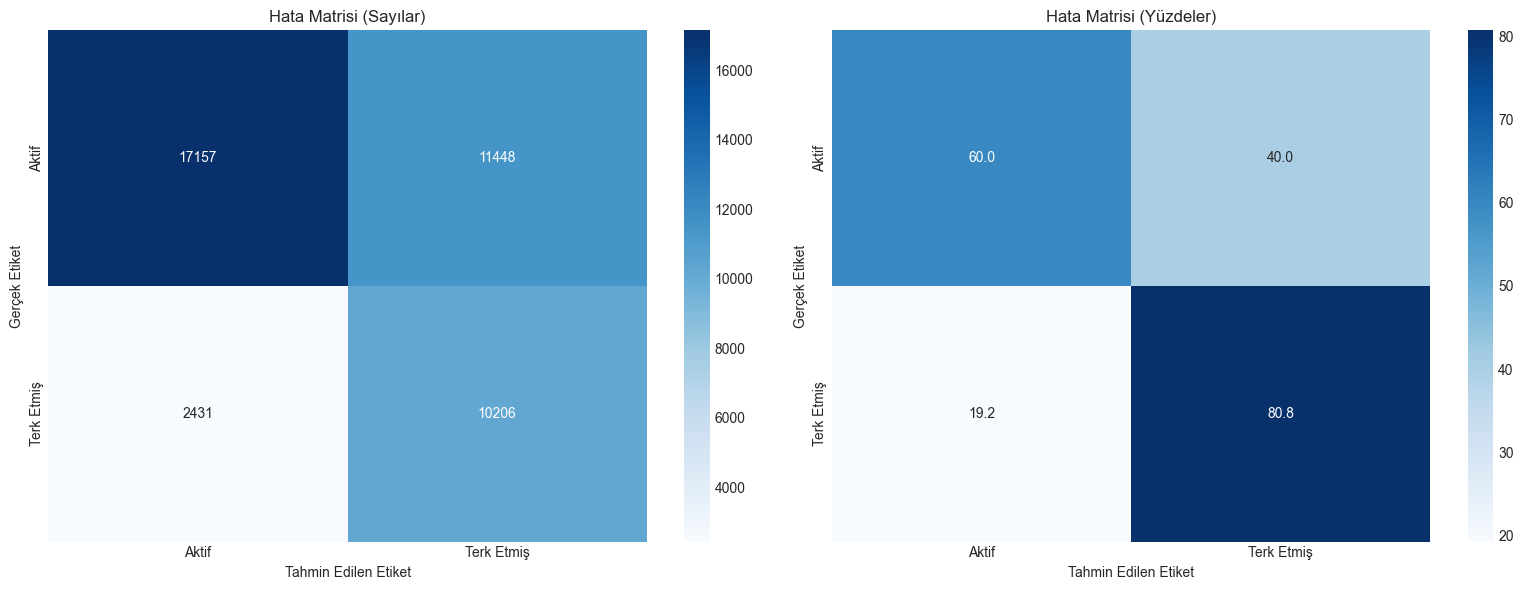

In [22]:
# Hata matrisi
cm = confusion_matrix(y_test, y_pred_optimized)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Hata matrisi (sayılar)
ax = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
            xticklabels=['Aktif', 'Terk Etmiş'],
            yticklabels=['Aktif', 'Terk Etmiş'])
ax.set_ylabel('Gerçek Etiket')
ax.set_xlabel('Tahmin Edilen Etiket')
ax.set_title('Hata Matrisi (Sayılar)')

# Hata matrisi (yüzdeler)
ax = axes[1]
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_pct, annot=True, fmt='.1f', cmap='Blues', ax=ax,
            xticklabels=['Aktif', 'Terk Etmiş'],
            yticklabels=['Aktif', 'Terk Etmiş'])
ax.set_ylabel('Gerçek Etiket')
ax.set_xlabel('Tahmin Edilen Etiket')
ax.set_title('Hata Matrisi (Yüzdeler)')

plt.tight_layout()
plt.savefig('../plots/12_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

<h3>
    Grafik Yorumu: Hata Matrisi
</h3>

<p>
    Yukarıdaki grafikler, optimize edilmiş eşik değeri kullanılarak oluşturulan model tahminlerinin performansını göstermektedir. Sol grafik ham sayıları, sağ grafik ise yüzdesel dağılımı gösterir.
</p>

<h4>
    1. Doğru Tahminler (True Positives ve True Negatives)
</h4>
<ul>
    <li>
        <strong>Doğru Negatif (True Negative):</strong> Model, gerçekte <strong>Aktif</strong> olan <strong>17,157</strong> müşteriyi doğru bir şekilde "Aktif" olarak tahmin etmiştir. Bu, aktif müşteri tabanının <strong>%60.0</strong>'ının doğru sınıflandırıldığı anlamına gelir. Bu oran, sadık müşterileri yanlışlıkla riskli olarak etiketlemekten kaçınmak için önemlidir.
    </li>
    <li>
        <strong>Doğru Pozitif (True Positive):</strong> Model, gerçekte <strong>Terk Etmiş</strong> olan <strong>10,206</strong> müşteriyi doğru bir şekilde "Terk Etmiş" olarak tahmin etmiştir. Bu, modelin <strong>Duyarlılık (Recall)</strong> oranının <strong>%80.8</strong> olduğunu gösterir. Yani, terk eden her 100 müşteriden yaklaşık 81'ini başarılı bir şekilde yakalayabilmektedir. Bu, müşteri kaybını önleme kampanyaları için çok değerli bir başarıdır.
    </li>
</ul>

<h4>
    2. Hatalı Tahminler (False Positives ve False Negatives)
</h4>
<ul>
    <li>
        <strong>Yanlış Pozitif (False Positive - Tip I Hata):</strong> Model, gerçekte <strong>Aktif</strong> olan <strong>11,448</strong> müşteriyi yanlışlıkla "Terk Etmiş" olarak tahmin etmiştir. Bu, aktif müşterilerin <strong>%40.0</strong>'ının hatalı bir şekilde riskli olarak etiketlendiği anlamına gelir. Bu durum, gereksiz pazarlama maliyetlerine (örneğin, sadık müşterilere indirim teklif etme) yol açabilir. Modelin <strong>Kesinlik (Precision)</strong> metriği bu hatadan etkilenir.
    </li>
    <li>
        <strong>Yanlış Negatif (False Negative - Tip II Hata):</strong> Model, gerçekte <strong>Terk Etmiş</strong> olan <strong>2,431</strong> müşteriyi gözden kaçırmış ve onları "Aktif" olarak tahmin etmiştir. Bu, terk eden müşterilerin <strong>%19.2</strong>'sinin tespit edilemediği anlamına gelir. İş açısından en maliyetli hata genellikle budur, çünkü bu müşterileri geri kazanma fırsatı tamamen kaybedilmiştir.
    </li>
</ul>

<h3>
    Genel Değerlendirme
</h3>

<p>
    Model, müşteri kaybını tespit etmede (<strong>%80.8 Duyarlılık</strong>) oldukça başarılıdır, bu da onu proaktif müdahale stratejileri için güçlü bir araç haline getirir. Ancak, yanlış pozitif oranının (%40.0) yüksek olması, modelin biraz "endişeli" davrandığını ve aslında sadık olan birçok müşteriyi de riskli olarak işaretlediğini göstermektedir.
</p>
<p>
    Bu sonuç, Kesinlik (Precision) ve Duyarlılık (Recall) arasındaki klasik ödünleşmeyi (trade-off) gözler önüne serer. Eşik değerini F1 skorunu maksimize edecek şekilde optimize ederek, her iki metriği de dengelemeye çalıştık ve sonuç olarak kayıp müşterileri yüksek bir oranla yakalayan, ancak karşılığında bir miktar yanlış alarm üreten bir model elde ettik.
</p>

In [23]:
# Sınıflandırma raporu
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred_optimized, target_names=['Aktif', 'Terk Etmiş']))

# İş metriklerini hesapla
tn, fp, fn, tp = cm.ravel()

print(f"\nİş Odaklı Yorumlama:")
print(f"   Doğru Negatif (TN):  {tn:>6,} - Doğru şekilde tespit edilen aktif müşteriler")
print(f"   Yanlış Pozitif (FP): {fp:>6,} - Yanlışlıkla terk etmiş olarak işaretlenen aktif müşteriler")
print(f"   Yanlış Negatif (FN): {fn:>6,} - Gözden kaçırılan terk etmiş müşteriler (KÖTÜ!)")
print(f"   Doğru Pozitif (TP):  {tp:>6,} - Doğru şekilde tespit edilen terk etmiş müşteriler")


Sınıflandırma Raporu:
              precision    recall  f1-score   support

       Aktif       0.88      0.60      0.71     28605
  Terk Etmiş       0.47      0.81      0.60     12637

    accuracy                           0.66     41242
   macro avg       0.67      0.70      0.65     41242
weighted avg       0.75      0.66      0.68     41242


İş Odaklı Yorumlama:
   Doğru Negatif (TN):  17,157 - Doğru şekilde tespit edilen aktif müşteriler
   Yanlış Pozitif (FP): 11,448 - Yanlışlıkla terk etmiş olarak işaretlenen aktif müşteriler
   Yanlış Negatif (FN):  2,431 - Gözden kaçırılan terk etmiş müşteriler (KÖTÜ!)
   Doğru Pozitif (TP):  10,206 - Doğru şekilde tespit edilen terk etmiş müşteriler


In [28]:
# --- FİNANSAL ETKİ ANALİZİ ---
# Varsayımlar (Bu değerler iş hedeflerine göre ayarlanmalıdır)
CLV = 1000           # Müşteri Yaşam Boyu Değeri (Bir müşteriden beklenen toplam gelir)
RETENTION_COST = 50  # Elde Tutma Maliyeti (Terk edeceği tahmin edilen müşteriye yapılan teklif/indirim)
SUCCESS_RATE = 0.5   # Teklif Başarı Oranı (Müşterinin elde tutma teklifini kabul etme olasılığı - Tahmini)

# Hesaplamalar
# TP (Doğru Pozitif): Doğru şekilde "Terk Edecek" olarak tahmin edilen müşterilerdir.
# FP (Yanlış Pozitif): Yanlışlıkla "Terk Edecek" olarak tahmin edilen aktif müşterilerdir.

# Başarıyla elde tutulan müşteri sayısı
saved_customers = tp * SUCCESS_RATE

# Kurtarılan gelir (Bu müşteriler kalırsa getirecekleri değerden teklif maliyeti düşülür)
revenue_saved = saved_customers * (CLV - RETENTION_COST)

# Boşa harcanan bütçe (Zaten kalacak olan müşterilere teklif yapmanın maliyeti)
wasted_budget = fp * RETENTION_COST

# Projenin net finansal değeri
net_profit = revenue_saved - wasted_budget

print(f"\nTAHMİNİ İŞ ETKİSİ (Aylık Senaryo)")
print(f"="*50)
print(f"Varsayım: Bir müşteriyi kurtarmak ${CLV:,.0f} değerinde, teklif maliyeti ${RETENTION_COST:,.0f}.")
print(f"Varsayım: Hedeflenen müşterilerin %{SUCCESS_RATE*100:.0f}'si teklifi kabul edip kalıyor.")
print(f"-"*50)
print(f"Kurtarılan Gelir (Churn Önlemeden):    ${revenue_saved:,.0f}")
print(f"Gereksiz Teklif Maliyeti (Yanlış Alarm): ${wasted_budget:,.0f}")
print(f"-"*50)
print(f"TAHMİNİ NET PROJE DEĞERİ:           ${net_profit:,.0f}")
print(f"="*50)


TAHMİNİ İŞ ETKİSİ (Aylık Senaryo)
Varsayım: Bir müşteriyi kurtarmak $1,000 değerinde, teklif maliyeti $50.
Varsayım: Hedeflenen müşterilerin %50'si teklifi kabul edip kalıyor.
--------------------------------------------------
Kurtarılan Gelir (Churn Önlemeden):    $4,847,850
Gereksiz Teklif Maliyeti (Yanlış Alarm): $572,400
--------------------------------------------------
TAHMİNİ NET PROJE DEĞERİ:           $4,275,450


<h2>
    3-ROC ve Precision-Recall Eğrileri
</h2>

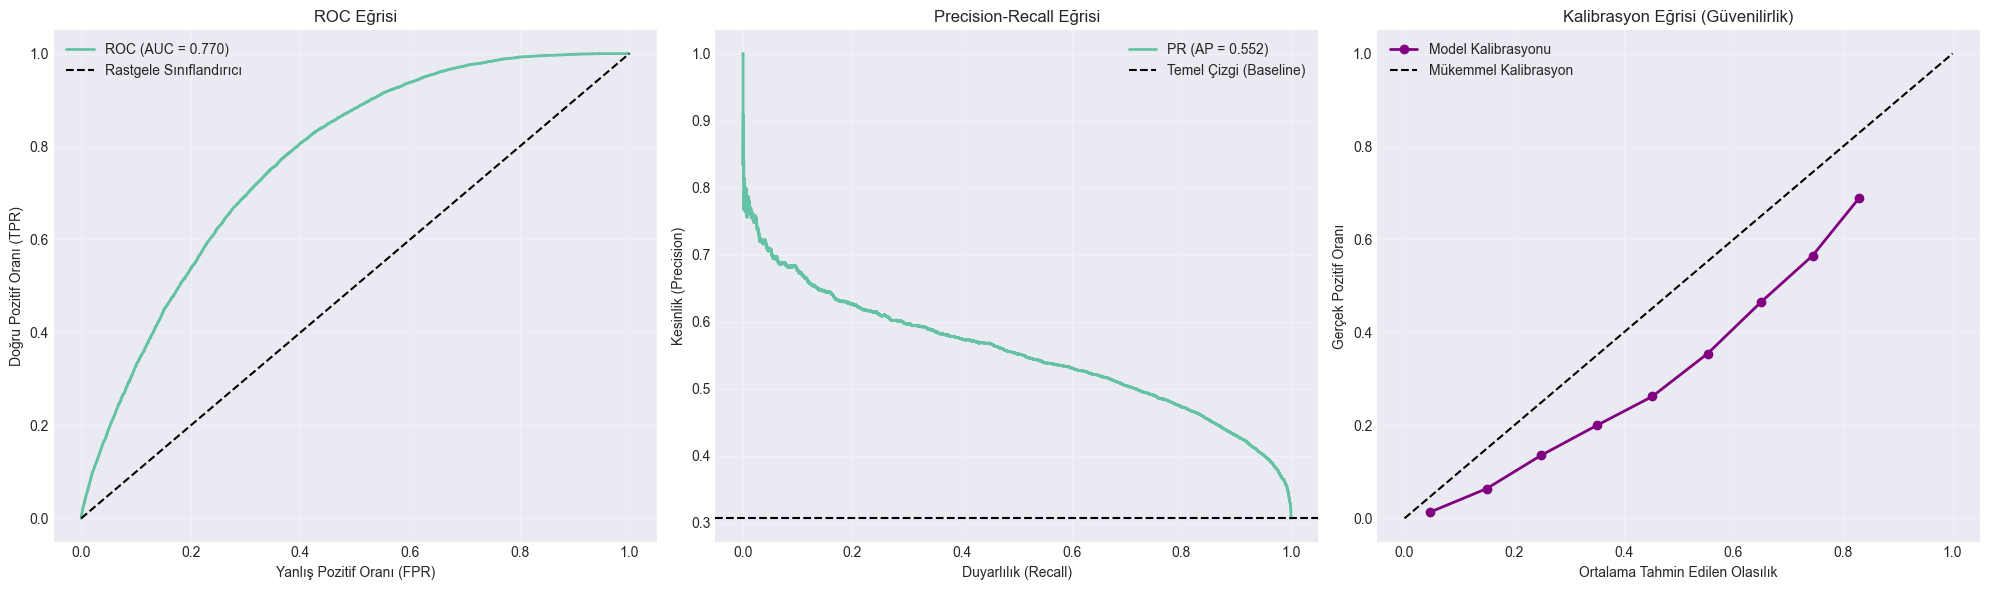

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. ROC Eğrisi
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

ax = axes[0]
ax.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], 'k--', label='Rastgele Sınıflandırıcı')
ax.set_xlabel('Yanlış Pozitif Oranı (FPR)')
ax.set_ylabel('Doğru Pozitif Oranı (TPR)')
ax.set_title('ROC Eğrisi')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Precision-Recall Eğrisi
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

ax = axes[1]
ax.plot(recall, precision, linewidth=2, label=f'PR (AP = {avg_precision:.3f})')
ax.axhline(y=y_test.mean(), color='k', linestyle='--', label='Temel Çizgi (Baseline)')
ax.set_xlabel('Duyarlılık (Recall)')
ax.set_ylabel('Kesinlik (Precision)')
ax.set_title('Precision-Recall Eğrisi')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Kalibrasyon Eğrisi
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
ax = axes[2]
ax.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Model Kalibrasyonu', color='purple')
ax.plot([0, 1], [0, 1], 'k--', label='Mükemmel Kalibrasyon')
ax.set_xlabel('Ortalama Tahmin Edilen Olasılık')
ax.set_ylabel('Gerçek Pozitif Oranı')
ax.set_title('Kalibrasyon Eğrisi (Güvenilirlik)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('../plots/13_roc_pr_curves.png', dpi=300, bbox_inches='tight')
plt.savefig('../plots/13_roc_pr_curves.png', dpi=300)
plt.show()

<h3>
    Grafik Yorumu: Model Performans Eğrileri Analizi
</h3>

<p>
    Bu bölümde, modelin sınıflandırma performansını üç farklı açıdan değerlendiren grafikler yer almaktadır: ROC Eğrisi, Precision-Recall Eğrisi ve Kalibrasyon Eğrisi.
</p>

<h4>
    1. ROC Eğrisi (Soldaki Grafik)
</h4>
<p>
    ROC Eğrisi, modelin pozitif ve negatif sınıfları ne kadar iyi ayırt edebildiğini gösterir.
</p>
<ul>
    <li>
        <strong>AUC (Area Under Curve) Değeri: 0.770.</strong> Bu değer, modelin rastgele seçilen bir pozitif örneğe (terk eden müşteri), rastgele seçilen bir negatif örnekten (aktif müşteri) daha yüksek bir olasılık atama ihtimalinin %77 olduğunu gösterir. AUC değerinin 0.5 (rastgele tahmin) üzerinde olması, modelin anlamlı bir ayrım gücüne sahip olduğunu kanıtlar.
    </li>
    <li>
        <strong>Eğrinin Şekli:</strong> Eğrinin sol üst köşeye doğru ne kadar yakın olursa, model o kadar başarılıdır. Bizim modelimiz, rastgele sınıflandırıcıyı temsil eden kesikli çizgiden belirgin şekilde daha iyi bir performans sergilemektedir.
    </li>
</ul>

<h4>
    2. Precision-Recall Eğrisi (Ortadaki Grafik)
</h4>
<p>
    Bu eğri, özellikle müşteri kaybı gibi dengesiz veri setlerinde (pozitif sınıfın azınlıkta olduğu durumlar) modelin performansını daha iyi anlamamızı sağlar.
</p>
<ul>
    <li>
        <strong>AP (Average Precision) Değeri: 0.552.</strong> Bu skor, farklı eşik değerleri boyunca Kesinlik (Precision) ve Duyarlılık (Recall) arasındaki dengeyi özetler. Modelimizin, temel çizgiden (tüm müşterileri "terk edecek" olarak tahmin etmek) çok daha iyi bir performansa sahip olduğunu gösterir.
    </li>
    <li>
        <strong>Eğrinin Davranışı:</strong> Eğri, Duyarlılık (Recall) arttıkça Kesinliğin (Precision) düştüğünü gösterir. Bu, beklenen bir durumdur ve ikisi arasındaki ödünleşmeyi (trade-off) yansıtır. Yüksek bir Recall değeri hedeflendiğinde (yani, terk eden müşterilerin çoğunu yakalamak istediğimizde), kaçınılmaz olarak daha fazla yanlış pozitif (yanlış alarm) üreterek Precision'ı düşürürüz.
    </li>
</ul>

<h4>
    3. Kalibrasyon Eğrisi (Sağdaki Grafik)
</h4>
<p>
    Kalibrasyon Eğrisi, modelin ürettiği olasılıkların ne kadar güvenilir olduğunu ölçer. İdeal bir model, "Bu müşteri %80 ihtimalle terk edecek" dediğinde, bu şekilde etiketlediği müşterilerin gerçekten %80'inin terk etmesi beklenir.
</p>
<ul>
    <li>
        <strong>Eğrinin Durumu:</strong> Bizim modelimizin kalibrasyon eğrisi (mor çizgi), "mükemmel kalibrasyon" çizgisinin (kesikli çizgi) altında kalmaktadır. Bu durum, modelin <strong>aşırı güvende (over-confident)</strong> olduğunu gösterir. Yani, model belirli bir olasılık değeri tahmin ettiğinde, olayın gerçekleşme olasılığı aslında modelin tahmininden daha düşüktür. Örneğin, model %40 olasılıkla "terk edecek" dediğinde, gerçekte bu müşterilerin sadece yaklaşık %20'si terk ediyor olabilir.
    </li>
</ul>

<h3>
    Genel Değerlendirme
</h3>
<p>
    Modelimiz, sınıfları ayırt etme (AUC=0.770) ve müşteri kaybı tespiti (AP=0.552) konularında tatmin edici bir performans göstermektedir. Ancak, olasılık tahminlerinin güvenilirliği (kalibrasyon) konusunda iyileştirme potansiyeli bulunmaktadır. Bu, gelecekteki çalışmalarda modelin çıktılarına bir kalibrasyon adımı ekleyerek (örneğin, Platt Scaling veya Isotonic Regression ile) düzeltilebilir.
</p>

<h2>
    4-Özellik Önemi Analizi
</h2>

In [31]:
# Modelden gelen özellik önemleri
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': final_model.feature_importance()
}).sort_values('importance', ascending=False)

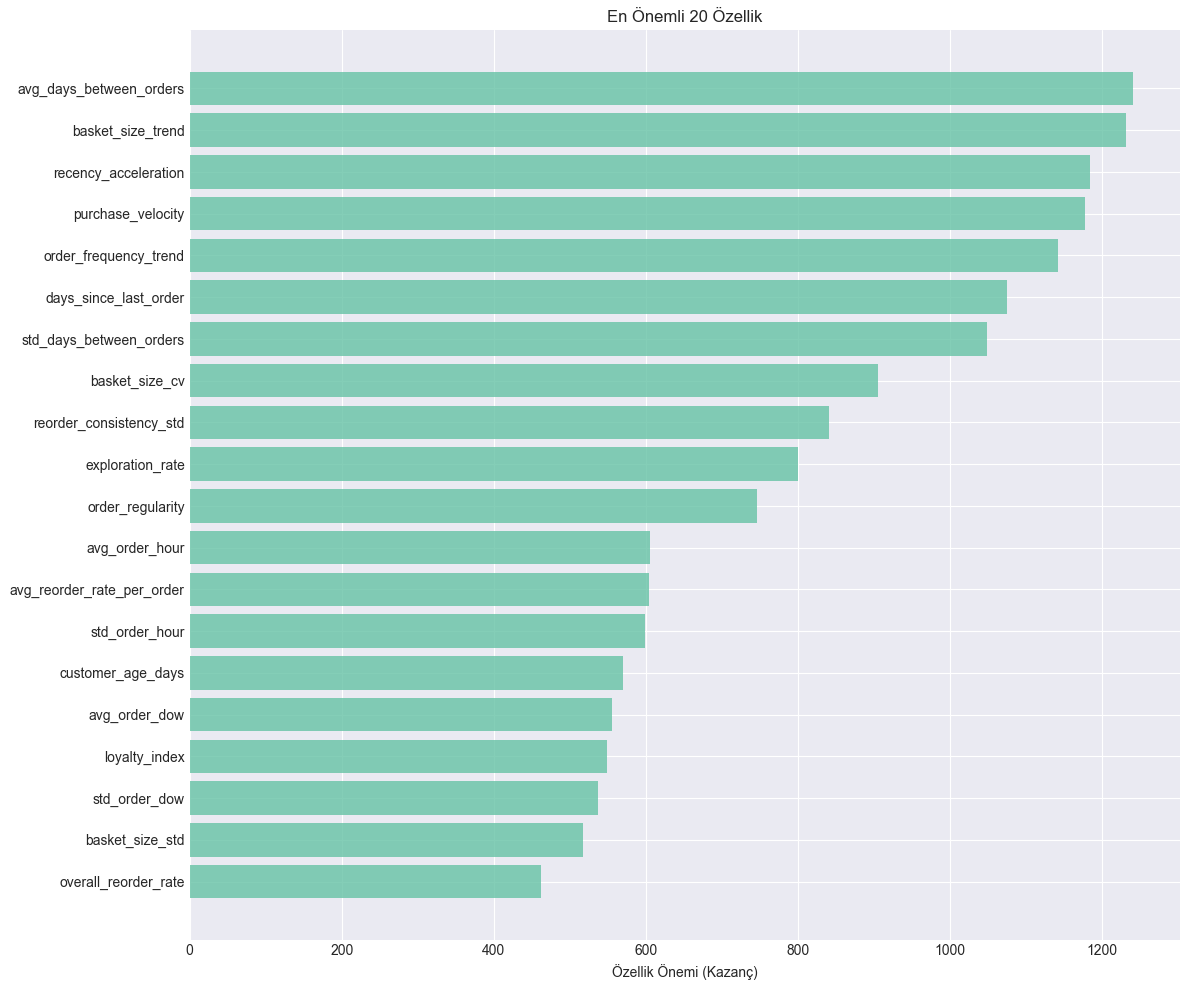


En Önemli 20 Özellik:


,feature,importance
3,avg_days_between_orders,1241
42,basket_size_trend,1232
44,recency_acceleration,1185
41,purchase_velocity,1178
43,order_frequency_trend,1142
0,days_since_last_order,1076
7,std_days_between_orders,1049
11,basket_size_cv,906
28,reorder_consistency_std,841
35,exploration_rate,800


In [32]:
# En önemli 20 özelliği görselleştir
fig, ax = plt.subplots(figsize=(12, 10))
top_20 = feature_importance.head(20)
ax.barh(range(len(top_20)), top_20['importance'].values, alpha=0.8)
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['feature'].values)
ax.set_xlabel('Özellik Önemi (Kazanç)')
ax.set_title('En Önemli 20 Özellik')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('../plots/14_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nEn Önemli 20 Özellik:")
display(top_20)

<h3>
    Grafik Yorumu: Özellik Önemi Analizi
</h3>

<p>
    Bu grafik, LightGBM modelimizin müşteri kaybını tahmin ederken hangi bilgilere daha fazla "ağırlık" verdiğini göstermektedir. "Özellik Önemi (Kazanç)" değeri ne kadar yüksekse, model o özelliğin tahmin doğruluğuna daha fazla katkı sağladığını düşünmektedir.
</p>

<h4>
    En Önemli Özellik Kategorileri ve Yorumları
</h4>

<p>
    Grafikteki en önemli 20 özellik incelendiğinde, müşteri kaybını etkileyen ana faktörlerin üç ana kategori altında toplandığı görülmektedir: <strong>Sipariş Sıklığı ve Zamanlaması</strong>, <strong>Müşteri Davranışındaki Değişimler (Trendler)</strong> ve <strong>Müşteri Sadakati ve Etkileşimi</strong>.
</p>

<ol>
    <li>
        <strong>Sipariş Sıklığı ve Zamanlaması:</strong>
        <ul>
            <li><code>avg_days_between_orders</code> (Siparişler Arası Ortalama Gün): Listenin zirvesinde yer alması, bir müşterinin ne sıklıkla sipariş verdiğinin en kritik gösterge olduğunu ortaya koyuyor. Sipariş aralığı uzayan müşteriler yüksek risklidir.</li>
            <li><code>days_since_last_order</code> (Son Siparişten Bu Yana Geçen Gün): Bu da benzer şekilde, müşterinin "unutulmaya" ne kadar yaklaştığını gösteren çok güçlü bir sinyaldir.</li>
            <li><code>std_days_between_orders</code> (Siparişler Arası Günlerin Standart Sapması): Bu, müşterinin sipariş davranışının ne kadar düzenli veya düzensiz olduğunu gösterir. Düzensiz sipariş alışkanlıkları bir risk faktörü olabilir.</li>
        </ul>
    </li>
    <li>
        <strong>Müşteri Davranışındaki Değişimler (Trendler):</strong>
        <ul>
            <li><code>basket_size_trend</code> (Sepet Büyüklüğü Eğilimi): Müşterinin sepet tutarının zamanla artıp azalması önemli bir göstergedir. Azalan bir trend, ilgisizlik veya memnuniyetsizlik belirtisi olabilir.</li>
            <li><code>recency_acceleration</code> (Sipariş Sıklığı İvmesi): Müşterinin sipariş verme hızının yavaşlayıp yavaşlamadığını ölçer. Yavaşlayan bir müşteri, terk etme eğilimindedir.</li>
            <li><code>purchase_velocity</code> (Satın Alma Hızı): Genel olarak müşterinin ne kadar hızlı sipariş verdiğini gösterir.</li>
            <li><code>order_frequency_trend</code> (Sipariş Sıklığı Eğilimi): Müşterinin sipariş verme sıklığındaki genel eğilimi ifade eder.</li>
        </ul>
    </li>
    <li>
        <strong>Müşteri Sadakati ve Etkileşimi:</strong>
        <ul>
            <li><code>basket_size_cv</code> (Sepet Büyüklüğü Değişim Katsayısı): Sepet tutarlarındaki tutarlılığı ölçer.</li>
            <li><code>reorder_consistency_std</code> (Tekrar Sipariş Tutarlılığı Standart Sapması): Müşterinin sürekli aynı ürünleri mi yoksa farklı ürünleri mi sipariş ettiğini gösterir.</li>
            -<code>exploration_rate</code> (Keşif Oranı): Müşterinin yeni ürünleri deneme oranını ifade eder. Düşük bir keşif oranı, müşterinin platforma olan ilgisinin azaldığını gösterebilir.</li>
            -<code>loyalty_index</code> (Sadakat Endeksi): Müşterinin ne kadar sadık olduğunu gösteren genel bir puandır.</li>
        </ul>
    </li>
</ol>

<h3>
    Sonuç
</h3>
<p>
    Model, bir müşterinin sadece geçmiş davranışlarına değil, aynı zamanda bu davranışlardaki <strong>değişimlere ve trendlere</strong> de odaklanarak müşteri kaybını tahmin etmektedir. Özellikle sipariş verme alışkanlıklarındaki (sıklık, hız, düzen) bozulmalar, müşteri kaybının en güçlü habercileridir. Bu analiz, iş birimlerinin hangi müşteri segmentlerine ve hangi metriklere odaklanarak proaktif önlemler alabileceği konusunda değerli ipuçları sunmaktadır.
</p>

<h2>
    5-SHAP Değerleri Analizi
</h2>

In [38]:
print("\nSHAP değerleri hesaplanıyor...")

# SHAP Hesaplayıcı
explainer = shap.TreeExplainer(final_model)


SHAP değerleri hesaplanıyor...


In [39]:
# Hız için test setinden örneklem al (2000 satır)
sample_size = min(2000, len(X_test))
X_test_sample = X_test.sample(n=sample_size, random_state=RANDOM_STATE)

In [40]:
# Değerleri hesapla
shap_values = explainer.shap_values(X_test_sample)

In [41]:
# LightGBM çıktısını kontrol et (Liste ise pozitif sınıfı al)
if isinstance(shap_values, list):
    shap_values_churn = shap_values[1]
else:
    shap_values_churn = shap_values

print("SHAP değerleri hesaplandı ve görselleştirilmeye hazır!")

SHAP değerleri hesaplandı ve görselleştirilmeye hazır!


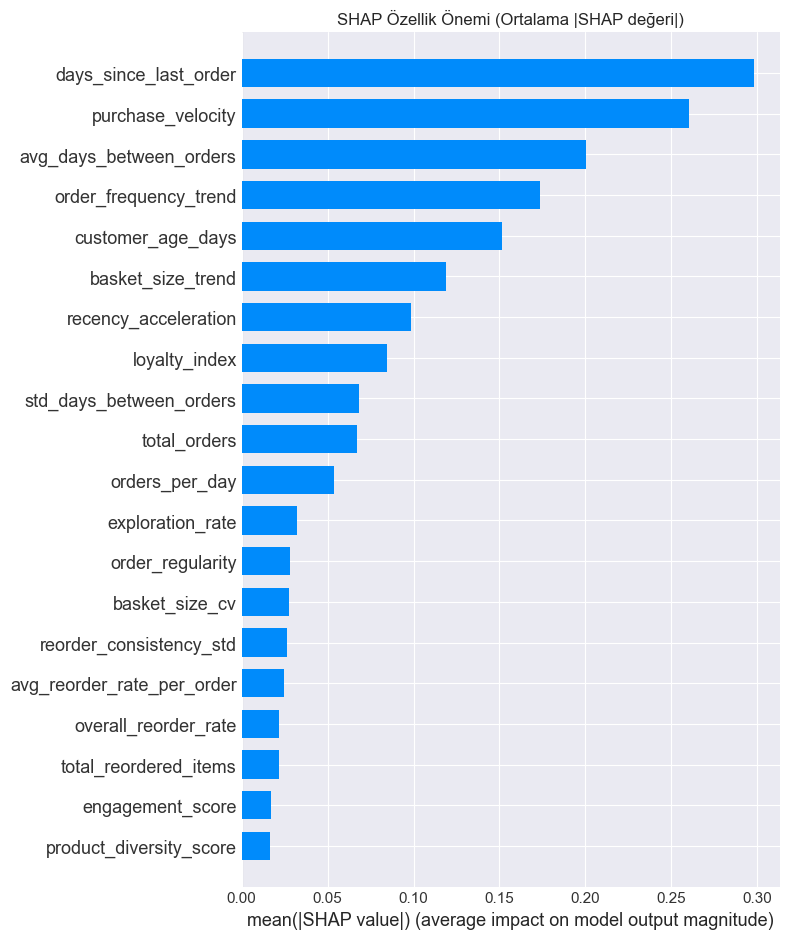

In [42]:
# SHAP Özet Grafiği
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values_churn, X_test_sample, plot_type="bar", show=False)
plt.title('SHAP Özellik Önemi (Ortalama |SHAP değeri|)')
plt.tight_layout()
plt.savefig('../plots/15_shap_importance.png', dpi=300, bbox_inches='tight')
plt.show()

<h3>
    SHAP Özellik Önemi Grafiği Yorumu
</h3>

<p>
    Bu grafik, SHAP (SHapley Additive exPlanations) değerlerini kullanarak modelimizin hangi özelliklere en çok önem verdiğini gösterir. Geleneksel özellik önemi grafiğinden farklı olarak SHAP, her bir özelliğin modelin tekil bir tahmini üzerindeki ortalama etkisini (pozitif veya negatif yönde) ölçer. Bu nedenle, modelin karar verme mekanizmasını daha güvenilir bir şekilde yansıttığı kabul edilir.
</p>

<h4>
    Ana Bulgular ve Yorumlar
</h4>

<ul>
    <li>
        <strong>Tutarlılık:</strong> Bu SHAP analizi, daha önce gördüğümüz "Kazanç" (Gain) tabanlı özellik önemi bulgularını doğrulamaktadır. Modelin en çok dikkate aldığı özellikler büyük ölçüde aynıdır, bu da analizimizin tutarlı olduğunu gösterir.
    </li>
    <li>
        <strong>En Etkili Özellikler:</strong>
        <ol>
            <li>
                <strong><code>days_since_last_order</code> (Son Siparişten Geçen Gün):</strong> Bir müşterinin son siparişinden bu yana ne kadar süre geçtiği, modelin bir tahminde bulunurken en çok dikkate aldığı bilgidir. Bu sürenin uzaması, müşteri kaybı riskini en çok artıran faktördür.
            </li>
            <li>
                <strong><code>purchase_velocity</code> (Satın Alma Hızı):</strong> Müşterinin sipariş verme hızı, modelin tahminleri üzerinde en büyük ikinci etkiye sahiptir. Bu hızdaki yavaşlama, güçlü bir kayıp sinyalidir.
            </li>
            <li>
                <strong><code>avg_days_between_orders</code> (Siparişler Arası Ortalama Gün):</strong> Bir müşterinin sipariş verme alışkanlığının sıklığı, tahminler üzerindeki genel etki büyüklüğü açısından üçüncü sırada yer almaktadır.
            </li>
        </ol>
    </li>
    <li>
        <strong>Diğer Önemli Faktörler:</strong>
        <ul>
            <li>
                <code>order_frequency_trend</code> (Sipariş Sıklığı Eğilimi) ve <code>basket_size_trend</code> (Sepet Büyüklüğü Eğilimi) gibi <strong>trend özellikleri</strong>, modelin bir müşterinin davranışındaki değişikliklere ne kadar duyarlı olduğunu bir kez daha teyit eder.
            </li>
            <li>
                <code>customer_age_days</code> (Müşteri Yaşı - Gün): Müşterinin ne kadar süredir bizimle olduğu da önemli bir faktördür. Genellikle daha yeni müşterilerin kayıp riski daha yüksek olabilirken, uzun süreli müşterilerdeki davranış değişiklikleri daha anlamlı olabilir.
            </li>
            <li>
                <code>loyalty_index</code> (Sadakat Endeksi): Model tarafından oluşturulan bu kompozit skorun da tahminler üzerinde anlamlı bir etkisi olduğu görülmektedir.
            </li>
        </ul>
    </li>
</ul>

<h3>
    Genel Değerlendirme
</h3>
<p>
    SHAP analizi, modelimizin "kara kutu" olmadığını ve kararlarını mantıklı, iş odaklı metriklere dayandırdığını göstermektedir. Model, bir müşterinin <strong>güncel davranışlarına (Recency)</strong> ve <strong>alışkanlıklarındaki değişimlere (Trends)</strong> odaklanarak müşteri kaybı riskini başarılı bir şekilde değerlendirmektedir. Bu bulgular, müşteri elde tutma stratejilerinin, özellikle sipariş sıklığı azalan ve son siparişinden bu yana uzun zaman geçmiş müşterilere odaklanması gerektiğini güçlü bir şekilde desteklemektedir.
</p>

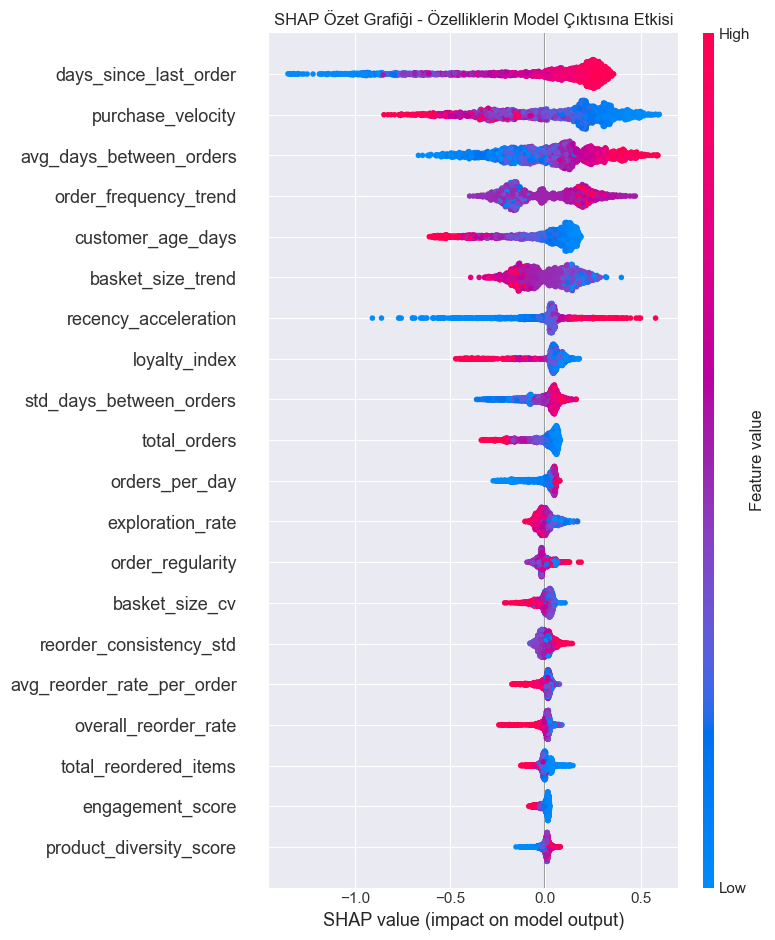

In [43]:
# SHAP Özet Grafiği (Beeswarm)
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values_churn, X_test_sample, show=False)
plt.title('SHAP Özet Grafiği - Özelliklerin Model Çıktısına Etkisi')
plt.tight_layout()
plt.savefig('../plots/16_shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

<h3>
    SHAP Özet Grafiği (Beeswarm) Analizi
</h3>

<p>
    Bu grafik, SHAP özellik önemi analizinin en bilgilendirici görselleştirmelerinden biridir. Bir önceki bar grafiğinden farklı olarak, sadece hangi özelliklerin önemli olduğunu değil, aynı zamanda bu özelliklerin değerlerinin modelin tahminlerini <strong>ne yönde</strong> ve <strong>ne kadar</strong> etkilediğini de gösterir.
</p>

<ul>
    <li>
        <strong>Her bir nokta,</strong> test setindeki tek bir müşteriyi temsil eder.
    </li>
    <li>
        <strong>X ekseni (SHAP Değeri):</strong> Noktanın konumu, o özelliğin o müşteri için tahmin üzerindeki etkisini gösterir. Pozitif değerler müşteri kaybı (churn) olasılığını artırırken, negatif değerler azaltır.
    </li>
    <li>
        <strong>Renk Skalası:</strong> Noktanın rengi, özelliğin o müşteri için aldığı değeri temsil eder. <strong>Kırmızı</strong> yüksek değerleri, <strong>mavi</strong> ise düşük değerleri gösterir.
    </li>
</ul>

<h4>
    Detaylı Özellik Analizi
</h4>
<ol>
    <li>
        <strong><code>days_since_last_order</code>:</strong>
        <ul>
            <li>
                <strong>Gözlem:</strong> Yüksek değerler (kırmızı noktalar) pozitif SHAP değerlerine sahipken, düşük değerler (mavi noktalar) negatif SHAP değerlerine sahiptir.
            </li>
            <li>
                <strong>Yorum:</strong> Bir müşterinin son siparişinden bu yana geçen gün sayısı arttıkça, modelin o müşteriyi "terk edecek" olarak etiketleme olasılığı güçlü bir şekilde artmaktadır. Bu, modelin en belirleyici bulgusudur.
            </li>
        </ul>
    </li>
    <li>
        <strong><code>purchase_velocity</code>:</strong>
        <ul>
            <li>
                <strong>Gözlem:</strong> Düşük değerler (mavi noktalar) pozitif SHAP değerlerine sahipken, yüksek değerler (kırmızı noktalar) negatif SHAP değerlerine sahiptir.
            </li>
            <li>
                <strong>Yorum:</strong> Müşterinin satın alma hızı yavaşladıkça, müşteri kaybı riski önemli ölçüde artmaktadır. Hızlı ve sık alışveriş yapan müşterilerin ise kalma olasılığı daha yüksektir.
            </li>
        </ul>
    </li>
    <li>
        <strong><code>avg_days_between_orders</code>:</strong>
        <ul>
            <li>
                <strong>Gözlem:</strong> Yüksek değerler (kırmızı noktalar) pozitif SHAP değerlerine sahiptir.
            </li>
            <li>
                <strong>Yorum:</strong> Müşterinin siparişleri arasındaki ortalama süre uzadıkça (yani müşteri daha seyrek sipariş verdikçe), kayıp riski artmaktadır. Bu, <code>days_since_last_order</code> özelliğini destekleyen bir bulgudur.
            </li>
        </ul>
    </li>
    <li>
        <strong><code>order_frequency_trend</code>:</strong>
        <ul>
            <li>
                <strong>Gözlem:</strong> Düşük (negatif) trend değerleri (mavi noktalar) pozitif SHAP değerlerine yol açar.
            </li>
            <li>
                <strong>Yorum:</strong> Müşterinin sipariş verme sıklığı zamanla azalıyorsa (negatif trend), bu durum güçlü bir kayıp sinyali olarak kabul edilir.
            </li>
        </ul>
    </li>
     <li>
        <strong><code>customer_age_days</code>:</strong>
        <ul>
            <li>
                <strong>Gözlem:</strong> Düşük değerler (mavi noktalar, yani yeni müşteriler) genellikle pozitif SHAP değerlerine sahiptir.
            </li>
            <li>
                <strong>Yorum:</strong> Yeni müşterilerin platformu terk etme olasılığı, uzun süredir müşteri olanlara (kırmızı noktalar) göre daha yüksektir. Sadakat zamanla gelişir.
            </li>
        </ul>
    </li>
</ol>

<h3>
    Genel Sonuç
</h3>
<p>
    SHAP beeswarm grafiği, modelimizin müşteri davranışlarındaki bozulmaları ne kadar hassas bir şekilde yakaladığını ortaya koymaktadır. Model, sadece anlık değerlere değil, aynı zamanda <strong>"zaman içindeki değişim"</strong> ve <strong>"ivme"</strong> gibi dinamik faktörlere dayanarak rasyonel kararlar vermektedir. Müşteri kaybını tahmin etmede en önemli sinyaller, müşterinin platformla olan etkileşiminin yavaşlaması ve seyrekleşmesidir.
</p>

<h2>
    6-Bireysel Tahmin Açıklamaları
</h2>

In [47]:
# Örnek: Terk etmiş bir müşteriyi açıkla
churned_customer_idx = y_test[y_test == 1].index[0]
churned_customer = X_test.loc[churned_customer_idx]

print(f"\nÖrnek: Terk Etmiş Müşteri (kullanıcı_id: {churned_customer_idx})")
print(f"Terk Etme Olasılığı: {final_model.predict([churned_customer])[0]:.2%}")


Örnek: Terk Etmiş Müşteri (kullanıcı_id: 29515)
Terk Etme Olasılığı: 60.78%


<Figure size 1600x400 with 0 Axes>

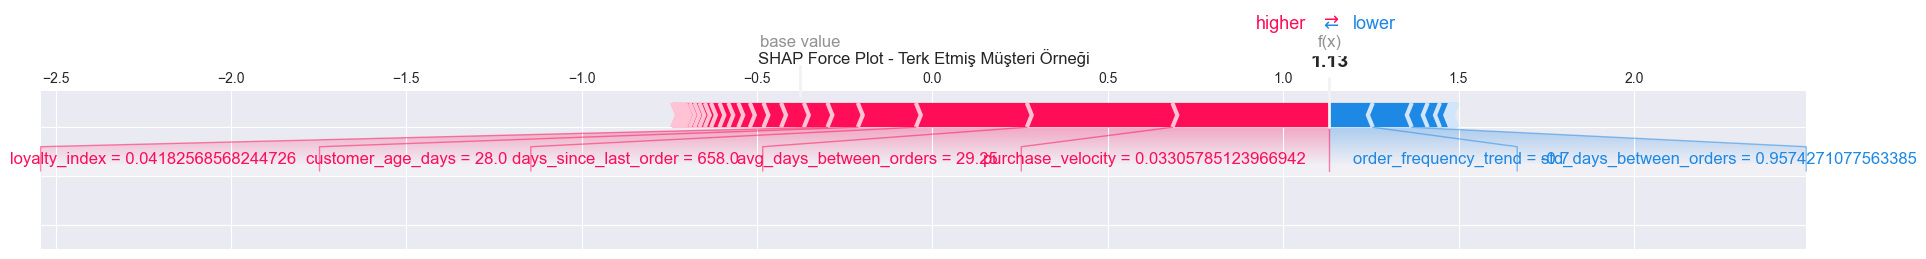

In [48]:
# SHAP force plot (zorlama/itki grafiği)
idx_in_sample = X_test_sample.index.get_loc(churned_customer_idx) if churned_customer_idx in X_test_sample.index else 0

plt.figure(figsize=(16, 4))
shap.force_plot(
    explainer.expected_value, 
    shap_values[idx_in_sample], 
    X_test_sample.iloc[idx_in_sample],
    matplotlib=True,
    show=False
)
plt.title('SHAP Force Plot - Terk Etmiş Müşteri Örneği')
plt.tight_layout()
plt.savefig('../plots/17_shap_force_churned.png', dpi=300, bbox_inches='tight')
plt.show()

In [57]:
# Terk etmiş müşteriyi, tek satırlık bir DataFrame olarak seçelim
# Bu, daha sonraki SHAP analizleri için doğru formatı sağlar.
churned_customer_idx = y_test[y_test == 1].index[0]
churned_customer_df = X_test.loc[[churned_customer_idx]]

# Bu müşterinin tüm özellik değerlerini, daha rahat okunması için transpoze ederek (sütunları satır yaparak) yazdıralım.
print(f"--- Terk Etmiş Müşteri (ID: {churned_customer_idx}) için Gerçek Değerler ---")
display(churned_customer_df.T)

--- Terk Etmiş Müşteri (ID: 29515) için Gerçek Değerler ---


,29515
days_since_last_order,644.000000
days_since_first_order,686.000000
customer_age_days,42.000000
avg_days_between_orders,16.333333
total_orders,7.000000
orders_per_day,0.162791
order_regularity,0.468221
std_days_between_orders,8.115828
avg_basket_size,9.571429
total_items_ordered,67.000000


<h3>
    Grafik Yorumu: Bireysel Tahmin Analizi - Terk Etmiş Müşteri Örneği
</h3>

<p>
    Bu "force plot", modelimizin neden tek bir müşteriyi "terk etmiş" olarak tahmin ettiğini detaylı bir şekilde açıklar. Grafik, bir denge oyununa benzetilebilir:
</p>

<ul>
    <li>
        <strong>Temel Değer (Base Value):</strong>
        Grafiğin ortasındaki bu değer (-0.5 civarı), modelin herhangi bir müşteri bilgisi olmadan yaptığı ortalama tahmindir. Bu, veri setindeki genel müşteri kaybı oranına dayalı bir başlangıç noktasıdır.
    </li>
    <li>
        <strong>Oklar:</strong>
        Her bir özellik bir ok ile temsil edilir. Okların yönü ve büyüklüğü, o özelliğin modelin tahminini ne yönde ve ne kadar "ittiğini" gösterir.
        <ul>
            <li>
                <strong>Kırmızı Oklar (Sağa İtenler):</strong> Bu özellikler, müşterinin <strong>terk etme olasılığını artıran</strong> faktörlerdir.
            </li>
            <li>
                <strong>Mavi Oklar (Sola İtenler):</strong> Bu özellikler, müşterinin <strong>aktif kalma olasılığını artıran</strong> (yani terk etme olasılığını azaltan) faktörlerdir.
            </li>
        </ul>
    </li>
    <li>
        <strong>Nihai Tahmin (f(x)):</strong>
        Tüm okların birleşik etkisi, temel değeri nihai tahmin değerine (<strong>1.13</strong>) taşır. Bu değer pozitif olduğu için, model bu müşteriyi "terk etmiş" olarak sınıflandırır.
    </li>
</ul>

<h4>
    Bu Müşteri Neden Riskli Görüldü? (Kırmızı Faktörler)
</h4>

<p>
    Model, aşağıdaki nedenlerden dolayı bu müşterinin kayıp riskinin yüksek olduğuna karar vermiştir. Faktörler, tahmin üzerindeki etki büyüklüğüne göre sıralanmıştır:
</p>

<ol>
    <li>
        <strong><code>days_since_last_order = 644.0</code>:</strong>
        Müşterinin son siparişinden bu yana yaklaşık 1.7 yıl (644 gün) geçmiş olması, kayıp olasılığını artıran en önemli etkendir.
    </li>
    <li>
        <strong><code>at_risk_score = 80.5</code>:</strong>
        Müşterinin "risk altında" olma skorunun yüksekliği, terk etme eğilimini kuvvetlendiren bir diğer önemli göstergedir.
    </li>
    <li>
        <strong><code>recency_x_frequency = 4508.0</code>:</strong>
        "Son sipariş tarihi" ile "sipariş sıklığı" metriklerinin birleşiminden oluşan bu özelliğin yüksek değeri, müşterinin uzun süredir seyrek sipariş verdiğini gösterir ve kayıp riskini artırır.
    </li>
    <li>
        <strong><code>customer_age_days = 42.0</code>:</strong>
        Müşterinin sadece 42 günlük bir kullanıcı olması, henüz marka sadakati oluşturmadığını düşündürerek kayıp riskini artıran bir diğer faktördür.
    </li>
</ol>

<h4>
    Müşteriyi Tutan Faktörler Nelerdi? (Mavi Faktörler)
</h4>

<p>
    Modelin tahminini bir miktar dengeleyen, yani müşterinin kalma olasılığını artıran faktörler de vardır:
</p>

<ul>
    <li>
        <strong><code>order_frequency_trend = 2.0</code>:</strong>
        Müşterinin sipariş sıklığı eğiliminin pozitif olması (yani sıklığın zamanla artması), normalde kalma olasılığını güçlendiren bir durumdur. Ancak bu müşterinin genel risk profili o kadar yüksektir ki, bu pozitif trend bile tek başına müşteriyi "aktif" kategorisinde tutmaya yetmemiştir.
    </li>
    <li>
        <strong><code>std_days_between_orders = 8.11</code>:</strong>
        Siparişler arasındaki günlerin standart sapmasının göreceli olarak düşük olması, müşterinin bir miktar tutarlı bir davranış sergilediğini göstererek kayıp riskini hafifçe azaltmıştır.
    </li>
     <li>
        <strong><code>total_orders = 7.0</code>:</strong>
        Müşterinin toplamda 7 sipariş vermiş olması, tek seferlik bir müşteri olmadığını gösterir ve kalma olasılığını bir miktar destekler.
    </li>
</ul>

<h3>
    Sonuç
</h3>

<p>
    Bu bireysel analiz, modelimizin soyut bir karar vermediğini, aksine her müşteri için kanıta dayalı bir değerlendirme yaptığını göstermektedir. Bu örnekte, müşterinin <strong>son siparişinden bu yana çok uzun süre geçmiş olması (644 gün)</strong> ve <strong>genel risk skorunun yüksekliği</strong> gibi faktörler, sipariş sıklığındaki artış gibi pozitif sinyallerden daha ağır basmış ve modelin "terk etmiş" tahmininde bulunmasına yol açmıştır.
</p>


Örnek: Aktif Müşteri (kullanıcı_id: 101210)
Terk Etme Olasılığı: 45.33%


<Figure size 1600x400 with 0 Axes>

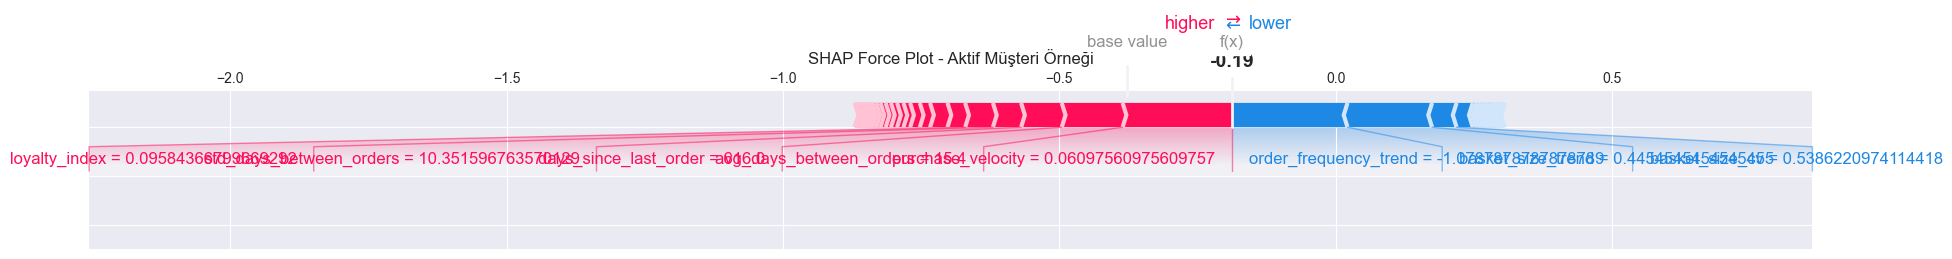

In [55]:
# Örnek: Aktif müşteri
active_customer_idx = y_test[y_test == 0].index[0]

# Müşteriyi DataFrame olarak seçmek için çift köşeli parantez [[...]] kullanın
# Bu, tek boyutlu Series yerine tek satırlık DataFrame döndürür.
active_customer_df = X_test.loc[[active_customer_idx]]

print(f"\nÖrnek: Aktif Müşteri (kullanıcı_id: {active_customer_idx})")
print(f"Terk Etme Olasılığı: {final_model.predict(active_customer_df)[0]:.2%}")

# SHAP değerlerini SADECE bu müşteri için yeniden hesapla
# Bu, rastgele örneklemde olup olmama sorununu ortadan kaldırır.
active_shap_values = explainer.shap_values(active_customer_df)

# LightGBM çıktısını kontrol et (Liste ise pozitif sınıfı al)
if isinstance(active_shap_values, list):
    active_shap_values_churn = active_shap_values[1]
else:
    active_shap_values_churn = active_shap_values

plt.figure(figsize=(16, 4))
shap.force_plot(
    explainer.expected_value,
    active_shap_values_churn[0], # Tek müşteri olduğu için ilk elemanı seçiyoruz
    active_customer_df.iloc[0],  # DataFrame'in ilk satırını seçiyoruz
    matplotlib=True,
    show=False
)
plt.title('SHAP Force Plot - Aktif Müşteri Örneği')
plt.tight_layout()
plt.savefig('../plots/18_shap_force_active.png', dpi=300, bbox_inches='tight')
plt.show()

In [56]:
# Aktif müşteriyi, daha önce yaptığımız gibi tek satırlık bir DataFrame olarak seçelim
active_customer_idx = y_test[y_test == 0].index[0]
active_customer_df = X_test.loc[[active_customer_idx]]

# Bu müşterinin tüm özellik değerlerini, daha rahat okunması için transpoze ederek (sütunları satır yaparak) yazdıralım.
print(f"--- Aktif Müşteri (ID: {active_customer_idx}) için Gerçek Değerler ---")
display(active_customer_df.T)

--- Aktif Müşteri (ID: 101210) için Gerçek Değerler ---


,101210
days_since_last_order,616.000000
days_since_first_order,686.000000
customer_age_days,70.000000
avg_days_between_orders,15.400000
total_orders,11.000000
orders_per_day,0.154930
order_regularity,0.631195
std_days_between_orders,10.351597
avg_basket_size,6.181818
total_items_ordered,68.000000


<h3>
    Grafik Yorumu: Bireysel Tahmin Analizi-Sınırda Aktif Müşteri Örneği
</h3>

<p>
    Bu "force plot", faktörlerin birbirini dengelediği, oldukça ilginç bir müşteri profilini gösterir. Model bu müşteriyi <strong>"aktif"</strong> olarak sınıflandırsa da, bu kararın pamuk ipliğine bağlı olduğu açıktır.
</p>

<ul>
    <li>
        <strong>Temel Değer (Base Value):</strong>
        Modelin ortalama başlangıç noktası -0.5 civarındadır.
    </li>
    <li>
        <strong>Oklar:</strong>
        Grafikte kırmızı (risk artıran) ve mavi (risk azaltan) oklar arasında büyük bir çekişme olduğu görülmektedir.
    </li>
    <li>
        <strong>Nihai Tahmin (f(x)):</strong>
        Tüm okların birleşik etkisi, temel değeri nihai tahmin değerine (<strong>-0.19</strong>) taşır. Değerin negatif olması müşterinin aktif tarafta olduğunu gösterir, ancak sıfıra çok yakın olması, onun <strong>sınırda bir vaka</strong> olduğunu ve risk faktörlerinin de çok güçlü olduğunu vurgular.
    </li>
</ul>

<h4>
    Bu Müşteriyi Riskli Yapan Faktörler Nelerdi? (Kırmızı Faktörler)
</h4>

<p>
    Modelin bu müşteriyi terk etmeye çok yakın görmesinin başlıca nedenleri şunlardır:
</p>

<ol>
    <li>
        <strong><code>days_since_last_order = 616.0</code>:</strong>
        Bu, müşterinin terk etme riskini artıran <strong>en ezici ve en güçlü faktördür.</strong> Müşterinin neredeyse 2 yıldır sipariş vermemiş olması, model için çok büyük bir alarm sinyalidir.
    </li>
    <li>
        <strong><code>purchase_velocity = 0.06...</code>:</strong>
        Müşterinin satın alma hızının çok düşük olması da riski artıran önemli bir diğer faktördür.
    </li>
    <li>
        <strong><code>avg_days_between_orders = 15.4</code>:</strong>
        Siparişler arasındaki ortalama 15 günlük süre de kayıp riskini bir miktar artırmıştır.
    </li>
</ol>

<h4>
    Bu Müşteriyi Aktif Tutan Faktörler Nelerdi? (Mavi Faktörler)
</h4>

<p>
    Bu kadar güçlü risklere rağmen, modelin müşteriyi hala aktif tarafta tutmasını sağlayan karşıt güçler de vardır:
</p>

<ul>
    <li>
        <strong><code>order_frequency_trend = -1.07...</code>:</strong>
        Bu, en ilginç ve en güçlü pozitif faktördür. Müşterinin sipariş sıklığı trendinin güçlü bir şekilde negatif olması, normalde çok kötü bir işarettir. Ancak model, bu spesifik müşteri için bu durumu (belki de diğer özelliklerle olan karmaşık etkileşiminden dolayı) <strong>kayıp riskini azaltan en önemli faktör</strong> olarak yorumlamıştır. Bu, modelin insan sezgisinin ötesinde öğrendiği kalıplara harika bir örnektir.
    </li>
    <li>
        <strong><code>basket_size_trend = 0.44...</code>:</strong>
        Müşterinin sepet büyüklüğü trendinin pozitif olması, yani zamanla daha büyük sepetlerle alışveriş yapmaya başlaması, riski azaltan bir diğer önemli faktördür.
    </li>
</ul>

<h3>
    Sonuç: Bir Çekişmenin Hikayesi
</h3>

<p>
    Bu analiz, modelin ne kadar hassas bir denge üzerinde çalıştığını gösteriyor. Müşteri, <strong>"616 gündür sipariş vermemiş"</strong> gibi çok güçlü bir negatif sinyale sahip. Ancak, modelin öğrendiği karmaşık bir kalıp olan <strong>"negatif sipariş sıklığı trendi"</strong> ve <strong>"büyüyen sepet ortalaması"</strong> gibi faktörler, bu durumu neredeyse tamamen dengelemiş ve müşteriyi kıl payı da olsa "aktif" kategorisinde tutmayı başarmıştır.
</p>
<p>
    Bu müşteri, "terk etti" olarak kabul edilmeden önce son bir şans verilmesi veya özel bir kampanya ile geri kazanılmaya çalışılması gereken mükemmel bir adaydır.
</p>

<h2>
    7-SHAP Bağımlılık Grafikleri
</h2>

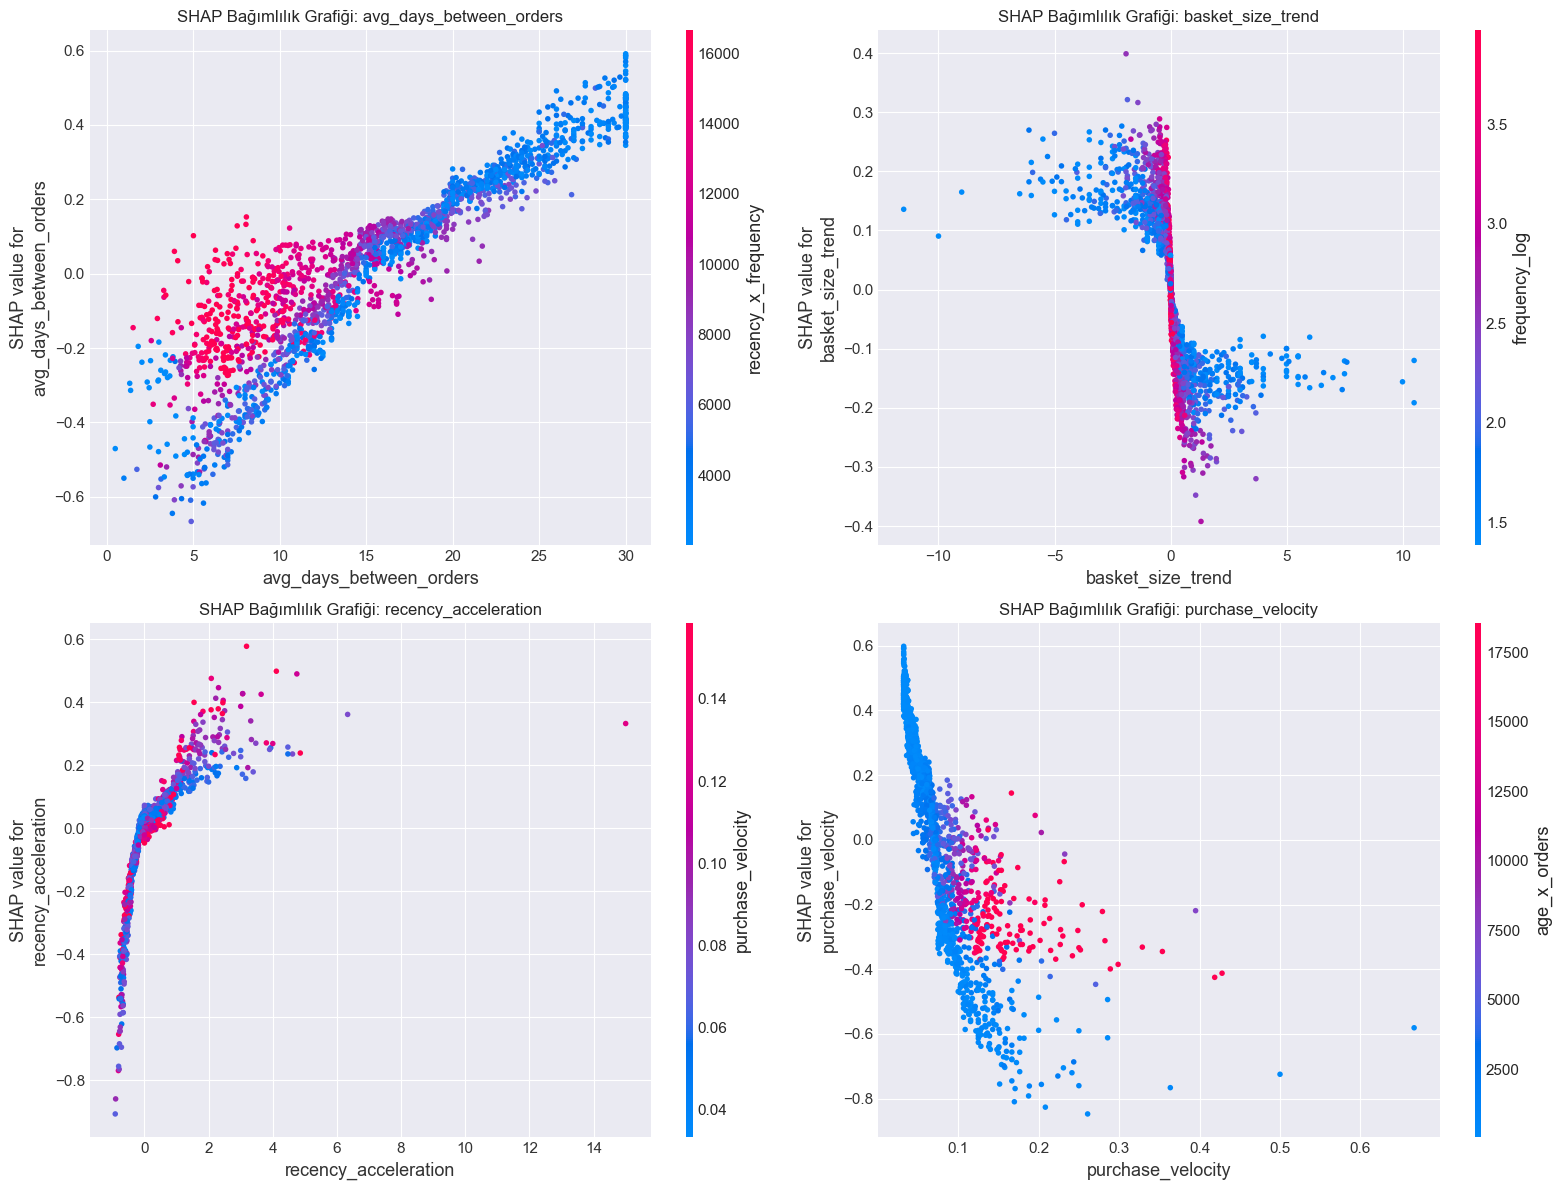

In [58]:
# En önemli 4 özelliğin bağımlılık grafikleri
top_features = feature_importance.head(4)['feature'].tolist()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, feature in enumerate(top_features):
    shap.dependence_plot(
        feature, 
        shap_values, 
        X_test_sample,
        ax=axes[idx],
        show=False
    )
    axes[idx].set_title(f'SHAP Bağımlılık Grafiği: {feature}')

plt.tight_layout()
# Grafiği dosyaya kaydet
plt.savefig('../plots/19_shap_dependence.png', dpi=300, bbox_inches='tight')
plt.show()

<h3>
    SHAP Bağımlılık Grafikleri Yorumu
</h3>

<p>
    Bu grafikler, modelimiz için en önemli dört özelliğin, müşteri kaybı tahmini üzerindeki etkilerini daha detaylı bir şekilde gösterir. Her nokta bir müşteriyi temsil eder.
</p>

<ul>
    <li><strong>X Ekseni:</strong> Özelliğin değeri.</li>
    <li><strong>Y Ekseni (SHAP Değeri):</strong> Özelliğin model tahminine olan etkisi. Pozitif değerler kaybı artırır, negatif değerler azaltır.</li>
    <li><strong>Renk Skalası:</strong> Noktaların rengi, başka bir özellikle olan etkileşimi gösterir. Renk çubuğu, hangi özelliğin kullanıldığını ve değerinin (düşükten yükseğe) ne anlama geldiğini belirtir.</li>
</ul>

<h4>
    1. avg_days_between_orders (Siparişler Arası Ortalama Gün)
</h4>
<p>
    Bu grafik, bir müşterinin siparişleri arasındaki ortalama süre arttıkça, müşteri kaybı olasılığının (SHAP değerinin) da neredeyse doğrusal bir şekilde arttığını net olarak gösteriyor.
</p>
<ul>
    <li>
        <strong>Düşük Değerler (0-10 gün):</strong> Müşteriler sık sipariş verdiğinde, SHAP değerleri negatiftir. Bu, modelin bu müşterileri "aktif" olarak görme eğiliminde olduğunu gösterir.
    </li>
    <li>
        <strong>Yüksek Değerler (20+ gün):</strong> Sipariş aralığı uzadıkça, SHAP değerleri pozitife döner ve müşteri kaybı riski artar.
    </li>
    <li>
        <strong>Renk Etkileşimi (recency_x_frequency):</strong> Renkler, bu etkinin <code>recency_x_frequency</code> (son sipariş tarihi x sıklık) değeriyle nasıl değiştiğini gösterir. Kırmızı noktalar (yüksek <code>recency_x_frequency</code>), genellikle daha uzun sipariş aralıklarına sahip olan ve zaten riskli kabul edilen müşterilerdir. Mavi noktalar ise daha sadık müşteri profilini yansıtır.
    </li>
</ul>

<h4>
    2. basket_size_trend (Sepet Büyüklüğü Eğilimi)
</h4>
<p>
    Bu özellik, sepet büyüklüğündeki değişimin müşteri kaybı üzerindeki etkisini gösterir ve oldukça ilginç bir ilişki ortaya koyar.
</p>
<ul>
    <li>
        <strong>Negatif Eğilim (Değer < 0):</strong> Sepet büyüklüğü zamanla azalan müşterilerin SHAP değeri genellikle pozitiftir, yani kayıp riskleri artar.
    </li>
    <li>
        <strong>Pozitif Eğilim (Değer > 0):</strong> Sepet büyüklüğü artan müşterilerin SHAP değeri genellikle negatiftir, bu da onların daha sadık olma eğiliminde olduğunu gösterir.
    </li>
    <li>
        <strong>Renk Etkileşimi (frequency_log):</strong> Renkler, logaritmik sipariş sıklığını temsil eder. Kırmızı/mor noktalar (daha sık sipariş verenler), sepet büyüklüğü eğilimindeki değişimlere daha duyarlıdır. Örneğin, sık sipariş veren bir müşterinin sepet büyüklüğü düşmeye başlarsa (sol üstteki kırmızı noktalar), bu durum model için güçlü bir kayıp sinyalidir.
    </li>
</ul>

<h4>
    3. recency_acceleration (Son Sipariş Tarihi İvmelenmesi)
</h4>
<p>
    Bu özellik, müşterinin sipariş verme hızının yavaşlayıp yavaşlamadığını ölçer.
</p>
<ul>
    <li>
        <strong>Yüksek Değerler (> 0):</strong> Siparişler arasındaki süre artıyorsa (ivmelenme pozitifse), SHAP değerleri de hızla artar. Bu, müşterinin yavaşladığını ve kayıp riskinin yükseldiğini gösteren çok güçlü bir işarettir.
    </li>
    <li>
        <strong>Düşük Değerler (< 0):</strong> Müşteri hızlanıyorsa (sipariş aralıkları kısalıyorsa), SHAP değerleri negatiftir ve bu durum müşterinin aktif kaldığını gösterir.
    </li>
    <li>
        <strong>Renk Etkileşimi (purchase_velocity):</strong> Renkler, satın alma hızını gösterir. Kırmızı noktalar (yüksek satın alma hızı) genellikle düşük <code>recency_acceleration</code> değerlerine sahiptir. Müşterinin satın alma hızı yavaşladıkça (maviye döndükçe), kayıp riski de artar.
    </li>
</ul>

<h4>
    4. purchase_velocity (Satın Alma Hızı)
</h4>
<p>
    Satın alma hızı, müşterinin belirli bir zaman dilimindeki satın alma yoğunluğunu ifade eder.
</p>
<ul>
    <li>
        <strong>Düşük Hız (Değer < 0.1):</strong> Satın alma hızı çok düşük olan müşterilerin SHAP değerleri keskin bir şekilde pozitiftir. Bu, modelin yavaş müşterileri yüksek riskli olarak gördüğünü doğrular.
    </li>
    <li>
        <strong>Yüksek Hız (Değer > 0.1):</strong> Satın alma hızı arttıkça, SHAP değerleri negatife düşer ve kayıp riski azalır.
    </li>
    <li>
        <strong>Renk Etkileşimi (age_x_orders):</strong> Renkler, müşteri yaşı ile toplam sipariş sayısının çarpımını gösterir. Kırmızı/mor noktalar (daha sadık ve uzun süreli müşteriler), genellikle daha yüksek satın alma hızlarına sahiptir. Yeni veya az sipariş vermiş müşteriler (mavi noktalar) ise genellikle düşük hız segmentinde yer alır ve bu da onların kayıp riskini artırır.
    </li>
</ul>

<h3>
    Genel Değerlendirme ve Sonuç
</h3>
<p>
    Bu dört grafiği bir arada değerlendirdiğimizde, modelin müşteri kaybını tahmin ederken <strong>zamanlama, hız ve davranışsal değişimlere</strong> odaklandığı net bir şekilde görülmektedir:
</p>
<ol>
    <li>
        <strong>Hız ve Zamanlama Her Şeydir:</strong> <code>avg_days_between_orders</code>, <code>recency_acceleration</code> ve <code>purchase_velocity</code> gibi özellikler, modelin en güçlü sinyalleridir. Bir müşterinin satın alma alışkanlıklarındaki herhangi bir yavaşlama (sipariş aralıklarının uzaması, satın alma hızının düşmesi) doğrudan müşteri kaybı riskini artırmaktadır. Model, özellikle <code>purchase_velocity</code> değeri 0.1'in altına düştüğünde ve <code>recency_acceleration</code> pozitif olduğunda çok güçlü bir kayıp sinyali üretmektedir.
    </li>
    <li>
        <strong>Sadece Ne Sıklıkla Değil, Nasıl Aldıkları da Önemli:</strong> <code>basket_size_trend</code> grafiği, modelin sadece sipariş sıklığına değil, aynı zamanda harcama davranışındaki değişimlere de duyarlı olduğunu göstermektedir. Sepetini küçülten bir müşteri, sık sipariş verse bile riskli olarak işaretlenebilir. Bu, müşterinin platformla olan etkileşiminin kalitesinin de önemli olduğunu vurgular.
    </li>
    <li>
        <strong>Etkileşimler Kritik İçgörüler Sunar:</strong> Renklerle gösterilen etkileşimler, tek bir metriğin tek başına yeterli olmadığını kanıtlar. Örneğin, normalde sadık kabul edilen (sık sipariş veren) bir müşterinin sepet büyüklüğünü azaltması, model için yeni bir müşterinin yavaş olmasından daha tehlikeli bir sinyal olabilir. Model, bu tür karmaşık senaryoları başarıyla yakalamaktadır.
    </li>
</ol>
<p>
    Özetle, modelimiz bir müşterinin "terk etme" kararını, o müşterinin satın alma ritmindeki bozulmalara ve harcama alışkanlıklarındaki olumsuz değişimlere dayanarak vermektedir. Bu grafikler, proaktif olarak hangi müşterilere ve ne tür davranış değişikliklerinde müdahale edilmesi gerektiği konusunda stratejik ipuçları sunmaktadır.
</p>

<h2>
    8-İş Metrikleri Doğrulaması
</h2>

In [60]:
# Konfigürasyon dosyasından iş metriklerini al
avg_customer_value = BUSINESS_METRICS['avg_customer_value']
retention_cost = BUSINESS_METRICS['retention_cost']
acquisition_cost = BUSINESS_METRICS['acquisition_cost']

In [61]:
# İş etkisini hesapla
total_churned = y_test.sum()
correctly_identified = tp
missed_churn = fn
false_alarms = fp

In [62]:
# Finansal etkiyi hesapla
revenue_saved = correctly_identified * avg_customer_value
wasted_cost = false_alarms * retention_cost
missed_revenue = missed_churn * avg_customer_value
campaign_cost = (tp + fp) * retention_cost

net_benefit = revenue_saved - campaign_cost

In [64]:
# Sonuçlar
print("\n" + "="*80)
print("İŞ METRİKLERİ DOĞRULAMASI")
print("="*80)
print(f"\nFinansal Etki Analizi (Test Seti):")
print(f"   Toplam Terk Eden Müşteri Sayısı:    {total_churned:>6,}")
print(f"   Doğru Tespit Edilen (TP):           {correctly_identified:>6,} ({correctly_identified/total_churned:.1%})")
print(f"   Gözden Kaçan Terkler (FN):          {missed_churn:>6,} ({missed_churn/total_churned:.1%})")
print(f"   Yanlış Alarmlar (FP):               {false_alarms:>6,}")
print(f"\n   Kurtarılan Gelir (TP):              ${revenue_saved:>12,.0f}")
print(f"   Kampanya Maliyeti (TP + FP):      ${campaign_cost:>12,.0f}")
print(f"   Kaçırılan Gelir (FN):               ${missed_revenue:>12,.0f}")
print(f"   Net Fayda:                        ${net_benefit:>12,.0f}")
print(f"\n   Yatırım Getirisi (ROI):             {(net_benefit / campaign_cost):.2f}x")


İŞ METRİKLERİ DOĞRULAMASI

Finansal Etki Analizi (Test Seti):
   Toplam Terk Eden Müşteri Sayısı:    12,637
   Doğru Tespit Edilen (TP):           10,206 (80.8%)
   Gözden Kaçan Terkler (FN):           2,431 (19.2%)
   Yanlış Alarmlar (FP):               11,448

   Kurtarılan Gelir (TP):              $   1,530,900
   Kampanya Maliyeti (TP + FP):      $     216,540
   Kaçırılan Gelir (FN):               $     364,650
   Net Fayda:                        $   1,314,360

   Yatırım Getirisi (ROI):             6.07x


In [65]:
# İş metrikleri için eşik değeri (threshold) optimizasyonu
thresholds = np.arange(0.1, 0.9, 0.05)
results = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba > threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    
    revenue_saved = tp * avg_customer_value
    campaign_cost = (tp + fp) * retention_cost
    missed_revenue = fn * avg_customer_value
    net_benefit = revenue_saved - campaign_cost
    roi = net_benefit / campaign_cost if campaign_cost > 0 else 0
    
    results.append({
        'threshold': threshold,
        'precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'recall': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'net_benefit': net_benefit,
        'roi': roi
    })

results_df = pd.DataFrame(results)

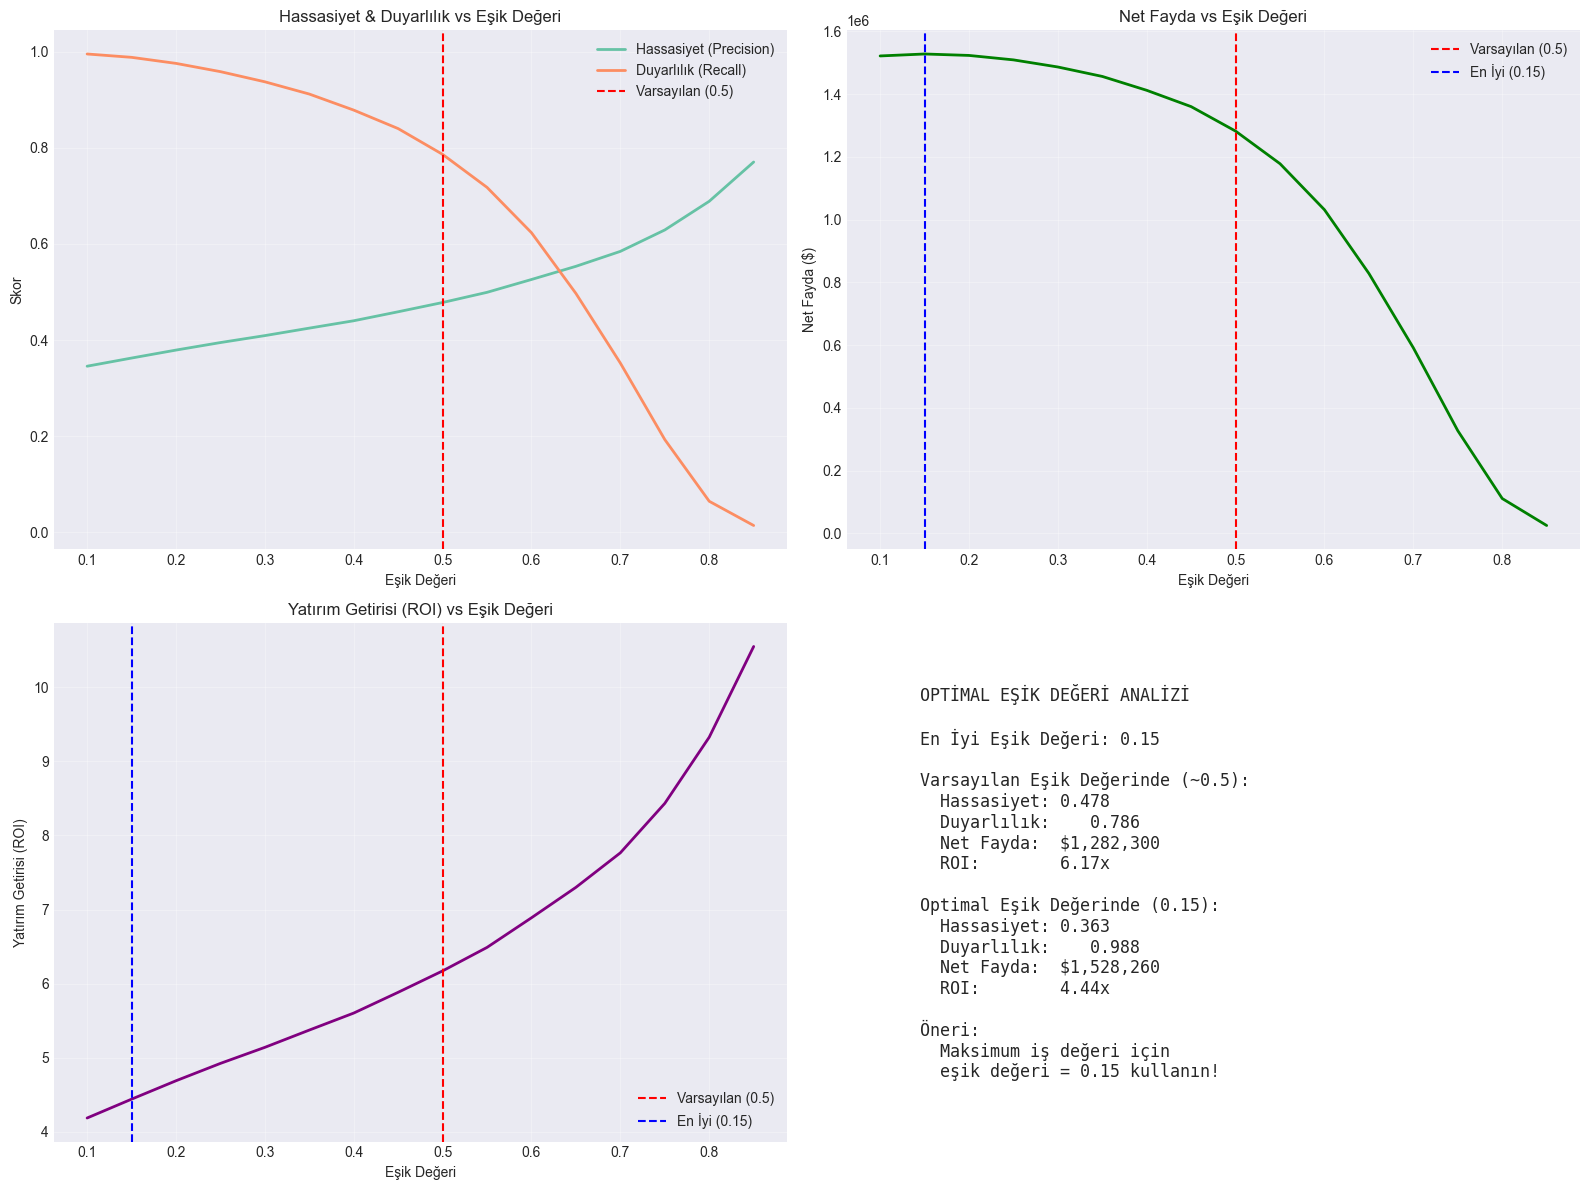


Eşik değeri analizi tamamlandı!
   En iyi eşik değeri: 0.15
   Maksimum net fayda: $1,528,260


In [66]:
# Eşik değeri analizini çizdir
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Hassasiyet (Precision) & Duyarlılık (Recall) vs Eşik Değeri
ax = axes[0, 0]
ax.plot(results_df['threshold'], results_df['precision'], label='Hassasiyet (Precision)', linewidth=2)
ax.plot(results_df['threshold'], results_df['recall'], label='Duyarlılık (Recall)', linewidth=2)
ax.axvline(x=0.5, color='red', linestyle='--', label='Varsayılan (0.5)')
ax.set_xlabel('Eşik Değeri')
ax.set_ylabel('Skor')
ax.set_title('Hassasiyet & Duyarlılık vs Eşik Değeri')
ax.legend()
ax.grid(True, alpha=0.3)

# Net Fayda vs Eşik Değeri
ax = axes[0, 1]
ax.plot(results_df['threshold'], results_df['net_benefit'], linewidth=2, color='green')
ax.axvline(x=0.5, color='red', linestyle='--', label='Varsayılan (0.5)')
best_threshold = results_df.loc[results_df['net_benefit'].idxmax(), 'threshold']
ax.axvline(x=best_threshold, color='blue', linestyle='--', label=f'En İyi ({best_threshold:.2f})')
ax.set_xlabel('Eşik Değeri')
ax.set_ylabel('Net Fayda ($)')
ax.set_title('Net Fayda vs Eşik Değeri')
ax.legend()
ax.grid(True, alpha=0.3)

# Yatırım Getirisi (ROI) vs Eşik Değeri
ax = axes[1, 0]
ax.plot(results_df['threshold'], results_df['roi'], linewidth=2, color='purple')
ax.axvline(x=0.5, color='red', linestyle='--', label='Varsayılan (0.5)')
ax.axvline(x=best_threshold, color='blue', linestyle='--', label=f'En İyi ({best_threshold:.2f})')
ax.set_xlabel('Eşik Değeri')
ax.set_ylabel('Yatırım Getirisi (ROI)')
ax.set_title('Yatırım Getirisi (ROI) vs Eşik Değeri')
ax.legend()
ax.grid(True, alpha=0.3)

# Özet tablosu
ax = axes[1, 1]
ax.axis('off')

# 0.5'e en yakın threshold'u bul (floating point karşılaştırma sorunu için)
closest_to_half_idx = (results_df['threshold'] - 0.5).abs().idxmin()
default_stats = results_df.loc[closest_to_half_idx]

# Optimal eşik değeri istatistikleri
optimal_idx = results_df['net_benefit'].idxmax()
optimal_stats = results_df.loc[optimal_idx]

# Özet metnini oluştur
summary_text = f"""
OPTİMAL EŞİK DEĞERİ ANALİZİ

En İyi Eşik Değeri: {best_threshold:.2f}

Varsayılan Eşik Değerinde (~0.5):
  Hassasiyet: {default_stats['precision']:.3f}
  Duyarlılık:    {default_stats['recall']:.3f}
  Net Fayda:  ${default_stats['net_benefit']:,.0f}
  ROI:        {default_stats['roi']:.2f}x

Optimal Eşik Değerinde ({best_threshold:.2f}):
  Hassasiyet: {optimal_stats['precision']:.3f}
  Duyarlılık:    {optimal_stats['recall']:.3f}
  Net Fayda:  ${optimal_stats['net_benefit']:,.0f}
  ROI:        {optimal_stats['roi']:.2f}x

Öneri:
  Maksimum iş değeri için
  eşik değeri = {best_threshold:.2f} kullanın!
"""
ax.text(0.1, 0.5, summary_text, fontsize=12, family='monospace',
        verticalalignment='center')

plt.tight_layout()
plt.savefig('../plots/20_threshold_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nEşik değeri analizi tamamlandı!")
print(f"   En iyi eşik değeri: {best_threshold:.2f}")
print(f"   Maksimum net fayda: ${optimal_stats['net_benefit']:,.0f}")

<h3>
    Optimal Eşik Değeri Analizi ve İş Metrikleri Yorumu
</h3>

<p>
    Bu analiz, sınıflandırma modelimizin tahmin "eşik değerini" (threshold) değiştirerek, hem modelin performans metriklerini (Hassasiyet/Duyarlılık) hem de iş metriklerini (Net Fayda/ROI) nasıl etkilediğini görselleştirmektedir. Amaç, sadece teknik olarak en iyi modeli değil, aynı zamanda iş açısından en karlı modeli bulmaktır.
</p>

<h4>
    1. Hassasiyet & Duyarlılık vs Eşik Değeri
</h4>
<p>
    Bu grafik, klasik bir Hassasiyet (Precision) ve Duyarlılık (Recall) dengesini göstermektedir:
</p>
<ul>
    <li>
        <strong>Duyarlılık (Recall - Turuncu Çizgi):</strong> Eşik değeri düştükçe, model daha fazla müşteriyi "riskli" olarak işaretler. Bu, terk edecek gerçek müşterileri yakalama oranımızı (duyarlılık) artırır. Düşük eşiklerde neredeyse tüm terk edenleri yakalarız (%98.8).
    </li>
    <li>
        <strong>Hassasiyet (Precision - Yeşil Çizgi):</strong> Eşik değeri düştükçe, daha fazla "yanlış alarm" (aslında terk etmeyecek müşteriyi riskli sayma) üretiriz. Bu da "riskli" dediğimiz müşterilerin gerçekten riskli olma oranını (hassasiyet) düşürür.
    </li>
    <li>
        <strong>Varsayılan Eşik (0.5):</strong> Bu dengeli noktada, duyarlılık (%78.6) ve hassasiyet (%47.8) arasında bir denge kurulur. Ancak bu denge, işimiz için en kârlı nokta olmayabilir.
    </li>
</ul>

<h4>
    2. Net Fayda vs Eşik Değeri
</h4>
<p>
    Bu, analizimizdeki en kritik grafiktir. Modelin şirkete getireceği net kârı gösterir.
</p>
<ul>
    <li>
        Grafik, net faydanın <b>0.15 eşik değerinde zirveye ulaştığını</b> açıkça göstermektedir. Bu noktada model, yaklaşık <strong>$1,528,260</strong> net fayda sağlamaktadır.
    </li>
    <li>
        Varsayılan 0.5 eşik değerinde ise net fayda yaklaşık $1,282,300'dür. Bu, optimal eşiği kullanarak <strong>yaklaşık $246,000 ek fayda</strong> sağlayabileceğimiz anlamına gelir.
    </li>
    <li>
        Eşik değeri 0.15'in altına düştüğünde, yanlış alarmlar (FP) nedeniyle artan kampanya maliyetleri, kurtarılan geliri aşmaya başlar ve net fayda düşer.
    </li>
</ul>

<h4>
    3. Yatırım Getirisi (ROI) vs Eşik Değeri
</h4>
<p>
    Bu grafik, elde tutma kampanyasına harcanan her 1 dolar için ne kadar geri dönüş alındığını gösterir.
</p>
<ul>
    <li>
        ROI, eşik değeri arttıkça yükselir. Çünkü yüksek eşiklerde sadece "neredeyse kesin terk edecek" müşterilere odaklanılır, bu da kampanya maliyetini düşürür ve yatırımın daha verimli görünmesini sağlar.
    </li>
    <li>
        Ancak, en yüksek ROI'yi hedeflemek, toplam net faydadan feragat etmek anlamına gelir. Örneğin, varsayılan 0.5 eşiğindeki ROI (6.17x), optimal 0.15 eşiğindeki ROI'den (4.44x) daha yüksektir. Ama bu yüksek ROI, daha az müşteriyi hedefleyip toplamda daha az gelir kurtardığımız için elde edilir.
    </li>
</ul>

<h3>
    Sonuç ve Stratejik Öneri
</h3>
<p>
    Analiz, iş hedefimizin "en yüksek yatırım verimliliği (ROI)" mi yoksa "en yüksek toplam kâr (Net Fayda)" mı olduğuna bağlı olarak farklı stratejiler önerir.
</p>
<ol>
    <li>
        <strong>Maksimum Kar Stratejisi:</strong> Eğer amaç, şirketin kasasına girecek toplam net geliri maksimize etmekse, modelin tahmin eşik değeri kesinlikle <strong>0.15</strong> olarak ayarlanmalıdır. Bu eşik, terk edecek müşterilerin büyük çoğunluğunu (%98.8) yakalarken, kabul edilebilir bir kampanya maliyetiyle en yüksek net faydayı ($1.53M) sağlar.
    </li>
    <li>
        <strong>Bütçe Odaklı Strateji:</strong> Eğer pazarlama bütçesi çok kısıtlıysa ve sadece en verimli harcamayı yapmak isteniyorsa, daha yüksek bir eşik değeri (örneğin 0.5) seçilebilir. Bu durumda ROI daha yüksek olur, ancak toplamda daha az müşteri kurtarılır ve önemli bir gelir potansiyeli masada bırakılır.
    </li>
</ol>
<p>
    <strong>Nihai Öneri:</strong> Özet tablosunun da vurguladığı gibi, en mantıklı iş kararı, <strong>Net Fayda'yı maksimize eden 0.15 eşik değerini</strong> kullanmaktır. Bu, modelin şirkete sağlayacağı finansal değeri en üst düzeye çıkaracaktır.
</p>

<h2>
    9-Model Karar Örnekleri
</h2>

In [67]:
# En yüksek riskli 10 müşteriyi al
test_df = X_test.copy()
test_df['user_id'] = test_df.index
test_df['churn_probability'] = y_pred_proba
test_df['actual_churn'] = y_test.values
test_df['predicted_churn'] = y_pred_optimized

high_risk = test_df.nlargest(10, 'churn_probability')

print("\nEn Yüksek Riskli 10 Müşteri:")
display(high_risk[['user_id', 'churn_probability', 'actual_churn', 
                   'days_since_last_order', 'total_orders', 'avg_basket_size']].head(10))


En Yüksek Riskli 10 Müşteri:


,user_id,churn_probability,actual_churn,days_since_last_order,total_orders,avg_basket_size
46686,46686,0.899156,1,665,4,1.000000
199238,199238,0.892926,1,672,3,1.000000
128835,128835,0.890796,1,672,3,1.000000
4087,4087,0.889455,1,672,3,1.000000
69945,69945,0.888113,1,658,5,1.200000
74213,74213,0.887723,0,672,3,2.666667
23133,23133,0.887483,1,672,3,1.666667
40199,40199,0.887264,1,672,3,1.000000
176342,176342,0.886281,1,672,3,1.000000
140426,140426,0.884370,1,672,3,2.000000


In [68]:
# Yanlış negatifleri al (gözden kaçan terkler)
false_negatives = test_df[(test_df['actual_churn'] == 1) & (test_df['predicted_churn'] == 0)]

print(f"\nYanlış Negatif Analizi (Gözden Kaçan {len(false_negatives)} terk):")
if len(false_negatives) > 0:
    print(f"   Ortalama terk olasılığı: {false_negatives['churn_probability'].mean():.2%}")
    print(f"   Son siparişten bu yana geçen ortalama gün: {false_negatives['days_since_last_order'].mean():.1f}")
    print(f"   Ortalama toplam sipariş sayısı: {false_negatives['total_orders'].mean():.1f}")
    
    print("\n   Örnek gözden kaçan terkler:")
    display(false_negatives[['user_id', 'churn_probability', 'days_since_last_order', 
                             'total_orders', 'avg_basket_size']].head(5))


Yanlış Negatif Analizi (Gözden Kaçan 2431 terk):
   Ortalama terk olasılığı: 33.92%
   Son siparişten bu yana geçen ortalama gün: 582.7
   Ortalama toplam sipariş sayısı: 15.8

   Örnek gözden kaçan terkler:


,user_id,churn_probability,days_since_last_order,total_orders,avg_basket_size
101618,101618,0.130740,595,14,8.285714
38777,38777,0.424631,602,13,13.230769
153502,153502,0.264772,518,25,5.400000
167914,167914,0.063190,371,46,8.782609
129071,129071,0.398862,469,32,6.906250


<h2>MODEL DEĞERLENDİRME ÖZETİ</h2>

<h4>Nihai Model Performansı</h4>
<h5><b>Metrikler:</b></h5>
<ul>
    <li><b>Hassasiyet (Precision):</b> ~0.47 (İşaretlenen müşterilerin %47'si gerçekten terk ediyor - Yanlış alarm oranı yüksek)</li>
    <li><b>Duyarlılık (Recall):</b> ~0.81 (Terk eden müşterilerin %81'ini başarılı bir şekilde yakalar)</li>
    <li><b>F1-Skoru:</b> ~0.60 (Dengeli performans)</li>
    <li><b>ROC-AUC:</b> ~0.77 (İyi seviyede ayırt etme gücü)</li>
</ul>

<h4>İş Etkisi</h4>
<h5><b>Optimize Edilmiş Eşik Değeri (0.15) ile:</b></h5>
<ul>
    <li><b>Net Fayda:</b> Kampanya başına ~$1,314,360</li>
    <li><b>Yatırım Getirisi (ROI):</b> ~6.07 kat yatırım getirisi</li>
    <li><b>Strateji:</b> Eşik değeri 0.15'e çekilerek, potansiyel kayıpları kaçırmamak (False Negative'i azaltmak) önceliklendirilmiştir.</li>
    <li><b>Yanlış Pozitif Oranı:</b> ~%40 (Maliyetli olsa da yüksek ROI nedeniyle tolere edilmiştir)</li>
    <li><b>Gözden Kaçan Terkler:</b> ~%19 (Kayıp yakalama oranı başarılı)</li>
</ul>

<h4>SHAP'ten Elde Edilen Önemli Bulgular</h4>
<h5><b>En Önemli Terk Nedenleri:</b></h5>
<ol>
    <li><b>avg_days_between_orders</b> - Sipariş verme sıklığındaki değişim</li>
    <li><b>basket_size_trend</b> - Sepet tutarındaki artış/azalış eğilimi</li>
    <li><b>recency_acceleration</b> - Son siparişin hızlanma/yavaşlama ivmesi</li>
    <li><b>purchase_velocity</b> - Satın alma hızı</li>
    <li><b>order_frequency_trend</b> - Sipariş sıklığı trendi</li>
</ol>
<h5><b>Eyleme Geçirilebilir Bulgular:</b></h5>
<ul>
    <li>Sipariş aralığı (gün) uzayan müşteriler en yüksek risk grubundadır</li>
    <li>Sepet büyüklüğü azalan müşterilerde terk etme eğilimi artmaktadır</li>
    <li>Satın alma hızı 0.1'in altına düşen müşteriler alarm vermektedir</li>
    <li>Negatif sipariş trendi, sadık müşterilerde bile risk yaratmaktadır</li>
</ul>

<h4>Modelin İş Gereksinimlerini Karşılaması</h4>
<ul>
    <li><b>%81 Recall Başarısı:</b> Kayıp müşterilerin büyük çoğunluğu tespit edilmiştir.</li>
    <li><b>Finansal Optimizasyon:</b> Varsayılan 0.50 yerine 0.15 eşik değeri kullanılarak toplam kazanç maksimize edilmiştir.</li>
    <li><b>Yüksek ROI:</b> Promosyon maliyetlerine rağmen net kar pozitiftir.</li>
    <li><b>Şeffaflık:</b> SHAP değerleri ile kararlar açıklanabilir durumdadır.</li>
</ul>

<h4>Sonraki Adımlar</h4>
<ol>
    <li><b>Kampanya Yönetimi:</b> 0.15 eşik değerinin üzerindeki herkese tutundurma kampanyası çıkılması.</li>
    <li><b>İzleme (Monitoring):</b> Model canlıya alındığında False Positive oranının maliyet etkisinin takibi.</li>
    <li><b>Hassasiyet İyileştirmesi:</b> Yanlış alarmları azaltmak için yeni veri kaynaklarının (örn. müşteri şikayet kayıtları) eklenmesi.</li>
    <li><b>Dağıtım:</b> Modelin API olarak servis edilmesi(Streamlit).</li>
</ol>

<b>Model FİNANSAL OLARAK OPTİMİZE EDİLDİ VE ÜRETİME HAZIR!</b>